# Lecture 2: Recurrent Neural Networks (RNN), LSTM & GRU -- From Scratch
## CSC5991 -- Introduction to Large Language Models (Slides 13-19)

**Student Notes by:** Anik Tahabilder | **Email:** tahabilderanik@gmail.com

---

**Welcome!** This notebook is written for students who have **never studied machine learning before**.
Every concept is explained from the ground up with detailed prose, line-by-line code comments,
diagrams drawn in text, and plenty of `print()` statements so you can inspect every intermediate value.

### What you will learn

| # | Topic | Slide |
|---|-------|-------|
| 1 | Why sequential / NLP tasks matter | 13 |
| 2 | A brief history of language models | 14 |
| 3 | Vanilla RNN -- theory + from-scratch NumPy code | 15-16 |
| 4 | Back-Propagation Through Time (BPTT) | 17 |
| 5 | The Vanishing / Exploding Gradient problem | 18-19 |
| 6 | LSTM -- theory + from-scratch NumPy code | 15 |
| 7 | GRU -- theory + from-scratch NumPy code | 15 |
| 8 | Big comparison table: RNN vs LSTM vs GRU | -- |
| 9 | A working character-level language model | -- |
| 10 | Summary, real-world analogies, key take-aways | -- |

> **Prerequisites:** Basic Python, basic linear algebra (matrix multiply), and curiosity. That is it!

In [1]:
# ============================================================
# IMPORTS -- we only need numpy and matplotlib for everything
# ============================================================
import numpy as np                 # numerical computing (matrices, vectors)
import matplotlib.pyplot as plt    # plotting / visualisation
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100   # nicer resolution for plots

# Reproducibility: fix the random seed so results are the same every run
np.random.seed(42)

print("All imports successful -- let's begin!")

All imports successful -- let's begin!


---
# 1. Our Focus -- Sequential Tasks (Slide 13)

## 1.1 What is a "sequential task"?

Imagine you are reading a sentence word by word:

> **"The cat sat on the ___"**

Even without finishing, your brain already guesses the next word might be *"mat"* or *"floor"*.
You can do this because **the order of words matters** -- language is *sequential*.

A **sequential task** is any task where the data comes in an ordered sequence and the meaning
depends on that order. Examples:

| Task | Input sequence | What we predict |
|------|---------------|-----------------|
| **Language Modelling** | previous words | next word |
| **Machine Translation** | sentence in English | sentence in French |
| **Text Generation** | a prompt / beginning | continuation text |
| **Speech Recognition** | audio frames over time | transcribed words |
| **Stock Price Prediction** | past prices | tomorrow's price |

## 1.2 The core idea -- next-token prediction

Given a sequence of tokens (words, characters, sub-words) $x_1, x_2, \ldots, x_{t-1}$,
our model must predict the next token $x_t$.

$$P(x_t \mid x_1, x_2, \ldots, x_{t-1})$$

### What is a "token"?
A **token** is the smallest unit the model works with. It could be:
- A **character**: `'h'`, `'e'`, `'l'`, `'l'`, `'o'`
- A **word**: `"hello"`, `"world"`
- A **sub-word** piece: `"hel"`, `"lo"` (used by modern LLMs like GPT)

## 1.3 Loss function -- maximise log-likelihood

To train the model we need to measure "how wrong" its predictions are. We use **log-likelihood**:

$$\mathcal{L} = -\sum_{t=1}^{T} \log P(x_t \mid x_1, \ldots, x_{t-1})$$

**Why the negative sign?** Probabilities are between 0 and 1. The log of a number between 0 and 1
is negative. The negative sign flips it positive so we can *minimise* the loss (smaller = better).

**Why logarithm?** Multiplying many small probabilities together gives a *tiny* number that computers
cannot represent accurately. Logs turn products into sums, which is numerically stable.

### Analogy
Think of the loss like a **golf score** -- lower is better. A perfect model would assign probability
1.0 to every correct next token, giving a loss of 0.

In [2]:
# ============================================================
# DEMO: Next-token prediction & log-likelihood loss
# ============================================================

# Suppose our vocabulary is just 4 words
vocabulary = ["the", "cat", "sat", "mat"]

# The model's predicted probability distribution for the next word
# (These would come from the neural network; here we make them up)
predicted_probs = {
    "the": 0.1,
    "cat": 0.2,
    "sat": 0.05,
    "mat": 0.65   # model thinks "mat" is most likely
}

# The TRUE next word is "mat"
true_next_word = "mat"

# Log-likelihood for this single prediction
prob_of_true = predicted_probs[true_next_word]        # 0.65
log_likelihood = np.log(prob_of_true)                  # log(0.65) ~ -0.43
neg_log_likelihood = -log_likelihood                   # 0.43 (our loss)

print("=" * 60)
print("NEXT-TOKEN PREDICTION DEMO")
print("=" * 60)
print(f"Vocabulary       : {vocabulary}")
print(f"Predicted probs  : {predicted_probs}")
print(f"True next word   : '{true_next_word}'")
print(f"P(true word)     : {prob_of_true}")
print(f"log P(true word) : {log_likelihood:.4f}")
print(f"Loss = -log P    : {neg_log_likelihood:.4f}")
print()
print("If the model were PERFECT (P=1.0):")
print(f"  Loss = -log(1.0) = {-np.log(1.0):.4f}  (best possible)")
print("If the model were TERRIBLE (P~0.01):")
print(f"  Loss = -log(0.01) = {-np.log(0.01):.4f}  (very high)")

NEXT-TOKEN PREDICTION DEMO
Vocabulary       : ['the', 'cat', 'sat', 'mat']
Predicted probs  : {'the': 0.1, 'cat': 0.2, 'sat': 0.05, 'mat': 0.65}
True next word   : 'mat'
P(true word)     : 0.65
log P(true word) : -0.4308
Loss = -log P    : 0.4308

If the model were PERFECT (P=1.0):
  Loss = -log(1.0) = -0.0000  (best possible)
If the model were TERRIBLE (P~0.01):
  Loss = -log(0.01) = 4.6052  (very high)


---
# 2. A Brief History of Language Models (Slide 14)

Language modelling has evolved through several major eras. Here is the timeline:

## Timeline Table

| Era | Period | Key Idea | Example Models |
|-----|--------|----------|----------------|
| **Statistical LM** | 1990s - 2000s | Count word co-occurrences; Markov assumption | n-gram models, Kneser-Ney smoothing |
| **Neural LM** | 2003 - 2013 | Use neural networks to learn word representations | Bengio (2003), Word2Vec (2013), RNN-LM |
| **Pre-trained LM** | 2018 - 2020 | Pre-train on huge text, then fine-tune for tasks | ELMo, BERT, GPT-2 |
| **Large LM (LLM)** | 2020 - present | Scale up parameters + data; emergent abilities | GPT-3, GPT-4, LLaMA, Claude |

## 2.1 Markov Chains & n-grams (Statistical era)

A **Markov Chain** says: "The probability of the next word depends *only* on the last few words."

- **Unigram** (n=1): $P(w_t)$ -- just word frequency, ignores context entirely.
- **Bigram** (n=2): $P(w_t \mid w_{t-1})$ -- depends on the previous word.
- **Trigram** (n=3): $P(w_t \mid w_{t-2}, w_{t-1})$ -- depends on the two previous words.

**Problem:** As n grows, the number of possible combinations *explodes*. Most n-grams are never
seen in training data ("data sparsity"). So statistical models are limited to very short context.

## 2.2 Neural language models (2003-2013)

Yoshua Bengio's 2003 paper showed that a **feed-forward neural network** could learn useful word
representations ("embeddings") and predict the next word better than n-grams.

In 2013, Tomas Mikolov introduced **Word2Vec**, showing that neural networks learn amazing
word relationships like `king - man + woman = queen`.

Around the same time, **Recurrent Neural Networks (RNNs)** and **LSTMs** were applied to language
modelling, achieving state-of-the-art results. This is what we study in this notebook!

## 2.3 The Transformer revolution (2017-2020)

In 2017, the paper "Attention Is All You Need" introduced the **Transformer** architecture, which
replaced RNNs with **self-attention**. This led to BERT (2018), GPT-2 (2019), and eventually the
large language models (LLMs) we use today. We will study Transformers in the next lecture!

```
Statistical LM ----> Neural LM ----> Pre-trained LM ----> LLM
  (n-grams)          (RNN/LSTM)       (BERT, GPT-2)      (GPT-4, Claude)
  1990s              2003-2013         2018-2020           2020-present
```

In [3]:
# ============================================================
# DEMO: Bigram language model (the simplest "AI" for text)
# ============================================================

corpus = "the cat sat on the mat the cat ate the rat"
words = corpus.split()   # split into a list of words

print("Corpus:", corpus)
print("Words :", words)
print()

# Step 1: Count bigram frequencies
# A bigram is a pair of consecutive words: (word_i, word_i+1)
bigram_counts = {}      # dictionary: (w1, w2) -> count
unigram_counts = {}     # dictionary: w1 -> count

for i in range(len(words) - 1):          # loop through all consecutive pairs
    w1 = words[i]                         # current word
    w2 = words[i + 1]                     # next word
    bigram = (w1, w2)
    bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1  # increment count
    unigram_counts[w1] = unigram_counts.get(w1, 0) + 1        # increment count

# Also count the last word as a unigram
unigram_counts[words[-1]] = unigram_counts.get(words[-1], 0) + 1

print("Bigram counts:")
for bigram, count in sorted(bigram_counts.items()):
    print(f"  {bigram}: {count}")

print()
print("Unigram counts:")
for word, count in sorted(unigram_counts.items()):
    print(f"  '{word}': {count}")

# Step 2: Compute bigram probabilities  P(w2 | w1) = count(w1,w2) / count(w1)
print()
print("Bigram probabilities P(next | current):")
for (w1, w2), count in sorted(bigram_counts.items()):
    prob = count / unigram_counts[w1]
    print(f"  P('{w2}' | '{w1}') = {count}/{unigram_counts[w1]} = {prob:.2f}")

# Step 3: Generate text using the bigram model
print()
print("--- Text Generation with Bigram Model ---")
current_word = "the"
generated = [current_word]

for _ in range(8):   # generate 8 more words
    # Find all bigrams starting with current_word
    candidates = []
    probs = []
    for (w1, w2), count in bigram_counts.items():
        if w1 == current_word:
            candidates.append(w2)
            probs.append(count / unigram_counts[w1])
    if not candidates:
        break
    probs = np.array(probs)
    probs = probs / probs.sum()   # normalise just in case
    next_word = np.random.choice(candidates, p=probs)  # sample next word
    generated.append(next_word)
    current_word = next_word

print("Generated:", " ".join(generated))

Corpus: the cat sat on the mat the cat ate the rat
Words : ['the', 'cat', 'sat', 'on', 'the', 'mat', 'the', 'cat', 'ate', 'the', 'rat']

Bigram counts:
  ('ate', 'the'): 1
  ('cat', 'ate'): 1
  ('cat', 'sat'): 1
  ('mat', 'the'): 1
  ('on', 'the'): 1
  ('sat', 'on'): 1
  ('the', 'cat'): 2
  ('the', 'mat'): 1
  ('the', 'rat'): 1

Unigram counts:
  'ate': 1
  'cat': 2
  'mat': 1
  'on': 1
  'rat': 1
  'sat': 1
  'the': 4

Bigram probabilities P(next | current):
  P('the' | 'ate') = 1/1 = 1.00
  P('ate' | 'cat') = 1/2 = 0.50
  P('sat' | 'cat') = 1/2 = 0.50
  P('the' | 'mat') = 1/1 = 1.00
  P('the' | 'on') = 1/1 = 1.00
  P('on' | 'sat') = 1/1 = 1.00
  P('cat' | 'the') = 2/4 = 0.50
  P('mat' | 'the') = 1/4 = 0.25
  P('rat' | 'the') = 1/4 = 0.25

--- Text Generation with Bigram Model ---
Generated: the cat ate the mat the cat sat on


---
# 3. Introduction to Recurrent Neural Networks (Slide 15)

## 3.1 The problem with feed-forward networks

A regular (feed-forward) neural network takes a **fixed-size** input and produces a **fixed-size**
output. But language has **variable length** -- sentences can be 3 words or 300 words.

Also, a feed-forward network has **no memory** -- it processes each input independently with no
knowledge of what came before.

## 3.2 The key idea of RNNs: a "memory" that carries forward

A **Recurrent Neural Network (RNN)** solves both problems:

1. It processes the input **one token at a time** (so it handles any length).
2. It maintains a **hidden state** $h_t$ that acts as a *memory* of everything seen so far.

```
    +----------+      +----------+      +----------+
    |  RNN     |      |  RNN     |      |  RNN     |
x_1-|  Cell    |-h_1--|  Cell    |-h_2--|  Cell    |-h_3-->
    |          |      |          |      |          |
    +----+-----+      +----+-----+      +----+-----+
         |                 |                 |
        y_1              y_2              y_3
```

At each time step $t$:
- The RNN receives the current input $x_t$ AND the previous hidden state $h_{t-1}$.
- It computes a new hidden state $h_t$ (updated memory).
- It optionally produces an output $\hat{y}_t$.

**The same weights are shared across all time steps** -- the RNN "cell" is reused.

## 3.3 Variants of RNNs

| Variant | Year | Key Idea | Advantage |
|---------|------|----------|-----------|
| **Vanilla RNN** | ~1986 | Simple recurrence | Easy to understand |
| **LSTM** | 1997 | Gates control information flow | Solves vanishing gradient |
| **GRU** | 2014 | Simplified LSTM with fewer gates | Faster to train, similar performance |

We will implement ALL THREE from scratch in this notebook.

## 3.4 RNN Unit vs LSTM Unit -- Architectural Diagram

```
================================================================
                    VANILLA RNN UNIT
================================================================

  h_{t-1} --+
             +----> [ tanh ] ----> h_t ----> (output layer) ----> y_t
  x_t    --+                       |
                                   +----> (passed to next time step)

  Only ONE operation: tanh(V*x_t + W*h_{t-1} + b)

================================================================
                       LSTM UNIT
================================================================

  c_{t-1} -------> [x forget] -----> [+ input] -----> c_t ----> next step
                       ^                  ^              |
                   forget_gate        input_gate         |
                       ^                  ^           [tanh]
  h_{t-1}--+      sigma(...)         sigma(...)         |
            +-->                                    [x output] ----> h_t
  x_t   --+                                            ^
                                                   output_gate
                                                       ^
  THREE gates: forget, input, output              sigma(...)
  PLUS a cell state c_t (long-term memory)
================================================================
```

---
# 4. Vanilla RNN -- The Equations (Slide 16)

## 4.1 The two equations that define a Vanilla RNN

At each time step $t$:

### Equation 1 -- Update the hidden state (memory):

$$h_t = f_h\!\left(V \cdot x_t \;+\; W \cdot h_{t-1} \;+\; b_h\right)$$

### Equation 2 -- Compute the output:

$$\hat{y}_t = f_y\!\left(U \cdot h_t \;+\; b_y\right)$$

Let us break down every symbol:

| Symbol | What it is | Shape | Learnable? |
|--------|-----------|-------|------------|
| $x_t$ | Input at time $t$ (e.g., a word embedding) | $(d_{in}, 1)$ | No (it is data) |
| $h_t$ | Hidden state at time $t$ (the "memory") | $(d_h, 1)$ | No (computed) |
| $h_{t-1}$ | Hidden state from the *previous* time step | $(d_h, 1)$ | No (computed) |
| $\hat{y}_t$ | Predicted output at time $t$ | $(d_{out}, 1)$ | No (computed) |
| $V$ | Weight matrix: input to hidden | $(d_h, d_{in})$ | **Yes** |
| $W$ | Weight matrix: hidden to hidden (recurrence!) | $(d_h, d_h)$ | **Yes** |
| $U$ | Weight matrix: hidden to output | $(d_{out}, d_h)$ | **Yes** |
| $b_h$ | Bias for hidden state | $(d_h, 1)$ | **Yes** |
| $b_y$ | Bias for output | $(d_{out}, 1)$ | **Yes** |
| $f_h$ | Activation function for hidden state (usually **tanh**) | -- | No |
| $f_y$ | Activation function for output (often **softmax** for classification) | -- | No |

## 4.2 Why tanh?

The **tanh** (hyperbolic tangent) function squashes values to the range $[-1, +1]$:

$$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

This keeps the hidden state values bounded and centred around zero, which helps training.

## 4.3 "Unrolling" the RNN across time steps

When we process a sequence of length $T$, we can visualise the RNN as if we made $T$ copies
of the same cell, each passing its hidden state to the next:

```
  x_1         x_2         x_3              x_T
   |           |           |                |
   v           v           v                v
+------+   +------+   +------+         +------+
|      |   |      |   |      |         |      |
| V,W  |-->| V,W  |-->| V,W  |--> ... | V,W  |
|  b_h | h1|  b_h | h2|  b_h |   hT-1 |  b_h |
+--+---+   +--+---+   +--+---+         +--+---+
   |           |           |                |
   v           v           v                v
  y_1        y_2        y_3              y_T

  L_1         L_2         L_3              L_T
   +___________+___________+________________+
                    Total Loss L = Sum of L_t
```

**Key insight:** The weights $V$, $W$, $U$, $b_h$, $b_y$ are **shared** (identical) across all time steps.
This is what makes an RNN efficient -- it does not need separate parameters for each position.

In [4]:
# ============================================================
# VANILLA RNN -- IMPLEMENTED FROM SCRATCH WITH NUMPY
# ============================================================
# We will build every piece by hand so you can see exactly
# what happens inside a Recurrent Neural Network.
#
# Architecture diagram (text-based):
#
#   x_t ----> [V] ---+
#                     +----> [+ b_h] ----> [tanh] ----> h_t ----> [U] ----> [+ b_y] ----> [softmax] ----> y_t
#   h_{t-1} ----> [W] ---+                               |
#                                                         +----> (next time step)

class VanillaRNN:
    '''
    A Vanilla Recurrent Neural Network implemented from scratch.

    Parameters
    ----------
    input_size  : int -- dimensionality of each input vector (d_in)
    hidden_size : int -- number of hidden units (d_h)
    output_size : int -- dimensionality of the output (d_out)
    '''

    def __init__(self, input_size, hidden_size, output_size):
        # Save dimensions for later use
        self.input_size = input_size    # e.g., vocabulary size (one-hot) or embedding dim
        self.hidden_size = hidden_size  # how many "memory cells"
        self.output_size = output_size  # e.g., vocabulary size for next-token prediction

        # -- Initialise weights with small random values --
        # Using Xavier/Glorot initialisation scaled by sqrt(1/n)
        scale_ih = np.sqrt(1.0 / hidden_size)   # scale for input-to-hidden
        scale_hh = np.sqrt(1.0 / hidden_size)   # scale for hidden-to-hidden
        scale_ho = np.sqrt(1.0 / output_size)   # scale for hidden-to-output

        # V: weight matrix from input to hidden  (shape: hidden_size x input_size)
        self.V = np.random.randn(hidden_size, input_size) * scale_ih

        # W: weight matrix from hidden to hidden (shape: hidden_size x hidden_size)
        # THIS is what makes the network "recurrent" -- it feeds h back into itself
        self.W = np.random.randn(hidden_size, hidden_size) * scale_hh

        # U: weight matrix from hidden to output (shape: output_size x hidden_size)
        self.U = np.random.randn(output_size, hidden_size) * scale_ho

        # b_h: bias for hidden state (shape: hidden_size x 1)
        self.b_h = np.zeros((hidden_size, 1))

        # b_y: bias for output (shape: output_size x 1)
        self.b_y = np.zeros((output_size, 1))

        print(f"VanillaRNN created:")
        print(f"  Input size  (d_in)  = {input_size}")
        print(f"  Hidden size (d_h)   = {hidden_size}")
        print(f"  Output size (d_out) = {output_size}")
        print(f"  V shape: {self.V.shape}  (input -> hidden)")
        print(f"  W shape: {self.W.shape}  (hidden -> hidden)")
        print(f"  U shape: {self.U.shape}  (hidden -> output)")
        print(f"  b_h shape: {self.b_h.shape}")
        print(f"  b_y shape: {self.b_y.shape}")
        total_params = (hidden_size * input_size +      # V
                        hidden_size * hidden_size +     # W
                        output_size * hidden_size +     # U
                        hidden_size +                   # b_h
                        output_size)                    # b_y
        print(f"  Total learnable parameters: {total_params}")

    @staticmethod
    def tanh(z):
        '''
        Hyperbolic tangent activation function.
        Squashes any real number into the range (-1, +1).
        '''
        return np.tanh(z)

    @staticmethod
    def softmax(z):
        '''
        Softmax function: converts raw scores (logits) into probabilities.
        Each output value is in (0,1) and they all sum to 1.
        We subtract max(z) for numerical stability (prevents overflow).
        '''
        e_z = np.exp(z - np.max(z))   # subtract max to avoid huge exponentials
        return e_z / e_z.sum(axis=0)   # divide each by the sum -> probabilities

    def forward(self, inputs, h_prev=None):
        '''
        Run the RNN forward through a sequence of inputs.

        Parameters
        ----------
        inputs : list of np.array, each of shape (input_size, 1)
            The input at each time step.
        h_prev : np.array of shape (hidden_size, 1) or None
            Initial hidden state. If None, starts with zeros.

        Returns
        -------
        outputs : list of np.array -- predicted probability distributions
        hiddens : list of np.array -- hidden states at each time step
        cache   : dict -- stored values needed for backpropagation
        '''
        T = len(inputs)   # sequence length (number of time steps)

        # If no initial hidden state provided, start with zeros
        if h_prev is None:
            h_prev = np.zeros((self.hidden_size, 1))

        # Storage for results and cache
        hiddens = []   # will store h_0, h_1, ..., h_T
        outputs = []   # will store y_1, y_2, ..., y_T
        cache = {
            'inputs': inputs,
            'hiddens': [h_prev],   # h_0 = initial state
            'z_h': [],             # pre-activation for hidden state
            'z_y': [],             # pre-activation for output
            'outputs': []
        }

        h_t = h_prev   # current hidden state (starts as h_0)

        for t in range(T):
            x_t = inputs[t]   # input at time t (shape: input_size x 1)

            # -- Equation 1: compute new hidden state --
            # z_h = V*x_t + W*h_{t-1} + b_h     (linear combination)
            z_h = self.V @ x_t + self.W @ h_t + self.b_h

            # h_t = tanh(z_h)                    (non-linear activation)
            h_t = self.tanh(z_h)

            # -- Equation 2: compute output --
            # z_y = U*h_t + b_y                  (linear combination)
            z_y = self.U @ h_t + self.b_y

            # y_t = softmax(z_y)                 (convert to probabilities)
            y_hat = self.softmax(z_y)

            # Store everything
            hiddens.append(h_t)
            outputs.append(y_hat)
            cache['hiddens'].append(h_t)
            cache['z_h'].append(z_h)
            cache['z_y'].append(z_y)
            cache['outputs'].append(y_hat)

        return outputs, hiddens, cache


# -- Create a small RNN and run a forward pass --
print("=" * 60)
print("Creating a Vanilla RNN")
print("=" * 60)
rnn = VanillaRNN(input_size=4, hidden_size=5, output_size=4)

# Create a dummy sequence of 3 one-hot vectors (vocabulary size = 4)
# One-hot means: only one element is 1, the rest are 0
# This represents 3 "words" from a vocabulary of 4 words
x1 = np.array([[1], [0], [0], [0]])   # word 0
x2 = np.array([[0], [1], [0], [0]])   # word 1
x3 = np.array([[0], [0], [1], [0]])   # word 2
inputs = [x1, x2, x3]

print("\n" + "=" * 60)
print("Running forward pass on sequence of length 3")
print("=" * 60)

outputs, hiddens, cache = rnn.forward(inputs)

for t in range(3):
    print(f"\n--- Time step t={t+1} ---")
    print(f"  Input x_{t+1}:       {inputs[t].flatten()}")
    print(f"  Hidden state h_{t+1}: {hiddens[t].flatten().round(4)}")
    print(f"  Output y_{t+1}:      {outputs[t].flatten().round(4)}")
    print(f"  Sum of y_{t+1}:      {outputs[t].sum():.6f}  (should be ~1.0)")

Creating a Vanilla RNN
VanillaRNN created:
  Input size  (d_in)  = 4
  Hidden size (d_h)   = 5
  Output size (d_out) = 4
  V shape: (5, 4)  (input -> hidden)
  W shape: (5, 5)  (hidden -> hidden)
  U shape: (4, 5)  (hidden -> output)
  b_h shape: (5, 1)
  b_y shape: (4, 1)
  Total learnable parameters: 74

Running forward pass on sequence of length 3

--- Time step t=1 ---
  Input x_1:       [1 0 0 0]
  Hidden state h_1: [ 0.6083 -0.2043 -0.6477 -0.3851  0.0302]
  Output y_1:      [0.186  0.169  0.3892 0.2558]
  Sum of y_1:      1.000000  (should be ~1.0)

--- Time step t=2 ---
  Input x_2:       [0 1 0 0]
  Hidden state h_2: [ 0.2087  0.4179  0.3322 -0.2376 -0.5721]
  Output y_2:      [0.1948 0.2886 0.1224 0.3941]
  Sum of y_2:      1.000000  (should be ~1.0)

--- Time step t=3 ---
  Input x_3:       [0 0 1 0]
  Hidden state h_3: [-0.1503  0.3332 -0.8357  0.7381  0.0665]
  Output y_3:      [0.2109 0.2439 0.3852 0.1599]
  Sum of y_3:      1.000000  (should be ~1.0)


---
# 5. Backpropagation Through Time -- BPTT (Slide 17)

## 5.1 How do neural networks learn?

Neural networks learn by adjusting their weights to **reduce the loss**. The algorithm is:

1. **Forward pass**: compute predictions and loss.
2. **Backward pass**: compute the *gradient* (derivative) of the loss with respect to each weight.
3. **Update weights**: nudge each weight in the direction that reduces the loss (gradient descent).

For RNNs, this process is called **Backpropagation Through Time (BPTT)** because we must backpropagate
the gradients backward through all the time steps.

## 5.2 The Forward Pass (recap)

At each time step $t$:

$$h_t = \tanh(V \cdot x_t + W \cdot h_{t-1} + b_h) \quad\text{(hidden state)}$$
$$\hat{y}_t = \text{softmax}(U \cdot h_t + b_y) \quad\text{(output)}$$
$$L_t = -\log(\hat{y}_t[y_t]) \quad\text{(loss at step t -- cross-entropy)}$$

Total loss over the full sequence:

$$L = \sum_{t=1}^{T} L_t = \sum_{t=1}^{T} -\log(\hat{y}_t[y_t])$$

## 5.3 The Backward Pass

We need these gradients to update the weights:

| Gradient | What it tells us |
|----------|-----------------|
| $\frac{\partial L}{\partial U}$ | How to adjust the hidden-to-output weights |
| $\frac{\partial L}{\partial b_y}$ | How to adjust the output bias |
| $\frac{\partial L}{\partial V}$ | How to adjust the input-to-hidden weights |
| $\frac{\partial L}{\partial W}$ | How to adjust the hidden-to-hidden weights (**hardest!**) |
| $\frac{\partial L}{\partial b_h}$ | How to adjust the hidden bias |

### Why is $\frac{\partial L}{\partial W}$ hard?

Because $W$ is used at **every** time step! The gradient must account for $W$'s influence on
$h_1$, which affects $h_2$, which affects $h_3$, and so on. This involves a **chain of derivatives**
that goes all the way back to $t=1$.

## 5.4 The chain rule through time

$$\frac{\partial L}{\partial W} = \sum_{t=1}^{T} \frac{\partial L_t}{\partial W}$$

$$\frac{\partial L_t}{\partial W} = \sum_{i=1}^{t} \frac{\partial L_t}{\partial h_t} \cdot \left(\prod_{j=i+1}^{t} \frac{\partial h_j}{\partial h_{j-1}}\right) \cdot \frac{\partial h_i}{\partial W}$$

That product $\prod_{j=i+1}^{t} \frac{\partial h_j}{\partial h_{j-1}}$ is the key.
It involves **multiplying many matrices** together -- and this is where trouble begins (vanishing/exploding gradients).

In [5]:
# ============================================================
# BPTT (Backpropagation Through Time) -- IMPLEMENTED FROM SCRATCH
# ============================================================
# We add a backward pass to our Vanilla RNN so we can compute
# gradients and see exactly how BPTT works.

def rnn_backward(rnn, cache, targets):
    '''
    Compute gradients using Backpropagation Through Time (BPTT).

    Parameters
    ----------
    rnn     : VanillaRNN -- the RNN whose gradients we compute
    cache   : dict -- stored values from the forward pass
    targets : list of np.array -- true outputs (one-hot vectors)

    Returns
    -------
    grads : dict -- gradients for V, W, U, b_h, b_y
    loss  : float -- total loss over the sequence
    '''
    T = len(targets)   # number of time steps

    # Initialise all gradients to zero (same shapes as the weights)
    dV = np.zeros_like(rnn.V)       # gradient of loss w.r.t. V
    dW = np.zeros_like(rnn.W)       # gradient of loss w.r.t. W
    dU = np.zeros_like(rnn.U)       # gradient of loss w.r.t. U
    db_h = np.zeros_like(rnn.b_h)   # gradient of loss w.r.t. b_h
    db_y = np.zeros_like(rnn.b_y)   # gradient of loss w.r.t. b_y

    # We also need the gradient flowing back through the hidden state
    dh_next = np.zeros((rnn.hidden_size, 1))  # gradient from future time step

    total_loss = 0.0

    # Iterate BACKWARD through time (from T-1 down to 0)
    for t in reversed(range(T)):
        # -- Retrieve cached values for this time step --
        y_hat = cache['outputs'][t]       # predicted probabilities (softmax output)
        h_t = cache['hiddens'][t + 1]     # hidden state at time t (index shifted by 1)
        h_prev = cache['hiddens'][t]      # hidden state at time t-1
        x_t = cache['inputs'][t]          # input at time t

        # -- Compute loss at this time step --
        # Cross-entropy loss: L_t = -log(y_t[correct_class])
        # targets[t] is a one-hot vector; we find the index of the 1
        target_idx = np.argmax(targets[t])
        loss_t = -np.log(y_hat[target_idx, 0] + 1e-12)  # add epsilon to avoid log(0)
        total_loss += loss_t

        # -- Gradient of loss w.r.t. softmax output --
        # For cross-entropy + softmax, the gradient is simply: y_hat - y (one-hot)
        dy = y_hat.copy()                 # shape: (output_size, 1)
        dy[target_idx] -= 1.0             # subtract 1 at the correct class position

        # -- Gradients for output layer (U, b_y) --
        # z_y = U*h_t + b_y, so:
        dU += dy @ h_t.T                  # (output_size, 1) @ (1, hidden_size) = (output_size, hidden_size)
        db_y += dy                        # (output_size, 1)

        # -- Gradient flowing back into h_t --
        # From the output layer: dh = U^T * dy
        dh = rnn.U.T @ dy                # (hidden_size, 1)

        # Add gradient from the NEXT time step (this is the "through time" part!)
        dh += dh_next                     # accumulate gradient from the future

        # -- Gradient through tanh --
        # h_t = tanh(z_h), so dz_h = dh * (1 - h_t^2)  [derivative of tanh]
        dz_h = dh * (1 - h_t ** 2)       # element-wise multiply

        # -- Gradients for hidden layer weights (V, W, b_h) --
        # z_h = V*x_t + W*h_{t-1} + b_h, so:
        dV += dz_h @ x_t.T               # (hidden_size, 1) @ (1, input_size)
        dW += dz_h @ h_prev.T            # (hidden_size, 1) @ (1, hidden_size)
        db_h += dz_h                      # (hidden_size, 1)

        # -- Gradient to pass to the previous time step --
        # h_{t-1} appears in z_h = ... + W*h_{t-1} + ...
        dh_next = rnn.W.T @ dz_h         # (hidden_size, 1)

    # Clip gradients to prevent explosion (a common practical trick)
    for grad in [dV, dW, dU, db_h, db_y]:
        np.clip(grad, -5, 5, out=grad)   # limit gradient values to [-5, +5]

    grads = {'dV': dV, 'dW': dW, 'dU': dU, 'db_h': db_h, 'db_y': db_y}
    return grads, total_loss

# -- Test BPTT on our earlier forward pass --
print("=" * 60)
print("BPTT Demo -- Computing Gradients")
print("=" * 60)

# Targets: the "correct" next word for each input (shifted by 1 for next-word prediction)
# Let's say the correct sequence is word1 -> word2 -> word3
t1 = np.array([[0], [1], [0], [0]])   # target at t=1: word 1
t2 = np.array([[0], [0], [1], [0]])   # target at t=2: word 2
t3 = np.array([[0], [0], [0], [1]])   # target at t=3: word 3
targets = [t1, t2, t3]

grads, loss = rnn_backward(rnn, cache, targets)

print(f"\nTotal loss: {loss:.4f}")
print(f"\nGradient shapes (should match weight shapes):")
print(f"  dV shape: {grads['dV'].shape}   (V shape: {rnn.V.shape})")
print(f"  dW shape: {grads['dW'].shape}   (W shape: {rnn.W.shape})")
print(f"  dU shape: {grads['dU'].shape}   (U shape: {rnn.U.shape})")
print(f"  db_h shape: {grads['db_h'].shape}")
print(f"  db_y shape: {grads['db_y'].shape}")

print(f"\nGradient magnitudes (Frobenius norms):")
for name, g in grads.items():
    print(f"  ||{name}|| = {np.linalg.norm(g):.6f}")

BPTT Demo -- Computing Gradients

Total loss: 5.7108

Gradient shapes (should match weight shapes):
  dV shape: (5, 4)   (V shape: (5, 4))
  dW shape: (5, 5)   (W shape: (5, 5))
  dU shape: (4, 5)   (U shape: (4, 5))
  db_h shape: (5, 1)
  db_y shape: (4, 1)

Gradient magnitudes (Frobenius norms):
  ||dV|| = 2.382615
  ||dW|| = 1.619417
  ||dU|| = 1.860863
  ||db_h|| = 1.500204
  ||db_y|| = 0.697163


---
# 6. The Vanishing & Exploding Gradient Problem (Slides 18-19)

## 6.1 Where the problem comes from

Recall the key formula for the gradient of the loss with respect to $W$:

$$\frac{\partial L_t}{\partial W} \propto \sum_{i=1}^{t} \underbrace{\left(\prod_{j=i+1}^{t} \frac{\partial h_j}{\partial h_{j-1}}\right)}_{\text{this is the problem!}} \cdot \frac{\partial h_i}{\partial W}$$

The gradient depends on a **product of many Jacobian matrices** $\frac{\partial h_j}{\partial h_{j-1}}$.

Since $h_j = \tanh(W \cdot h_{j-1} + \ldots)$, we have:

$$\frac{\partial h_j}{\partial h_{j-1}} = \text{diag}(1 - h_j^2) \cdot W$$

The **norm** of this matrix determines what happens when we multiply many of them together:

## 6.2 Two scenarios

### Scenario A: Vanishing Gradients ( $\left\|\frac{\partial h_j}{\partial h_{j-1}}\right\| < 1$ )

When the spectral norm (largest eigenvalue) is less than 1, each multiplication **shrinks** the
gradient. After many time steps, the gradient becomes **exponentially small** -- essentially zero.

$$\prod_{j=i+1}^{t} \left\|\frac{\partial h_j}{\partial h_{j-1}}\right\| \approx \lambda^{t-i} \xrightarrow{t-i \to \infty} 0$$

**Consequence:** The network **cannot learn long-range dependencies**. It "forgets" about inputs
that happened many steps ago, because the gradient signal from those inputs vanishes before it
reaches the weight update.

### Scenario B: Exploding Gradients ( $\left\|\frac{\partial h_j}{\partial h_{j-1}}\right\| > 1$ )

When the spectral norm is greater than 1, each multiplication **amplifies** the gradient.
After many time steps, the gradient becomes **exponentially large** -- infinity.

$$\prod_{j=i+1}^{t} \left\|\frac{\partial h_j}{\partial h_{j-1}}\right\| \approx \lambda^{t-i} \xrightarrow{t-i \to \infty} \infty$$

**Consequence:** The weight updates become **enormous**, causing the training to diverge
(weights jump around wildly and the loss goes to infinity).

## 6.3 The Long-Range Memory problem

Because of vanishing gradients, Vanilla RNNs struggle with sentences like:

> "The **cat**, which was sitting on the mat in the living room next to the fireplace, **was** happy."

The verb "was" needs to agree with "cat" (singular), but there are many words in between.
The gradient signal from "was" back to "cat" passes through all those intermediate time steps
and **vanishes** before reaching "cat". The RNN cannot learn this dependency.

This is exactly why **LSTM** and **GRU** were invented -- they solve the vanishing gradient problem!

## 6.4 Solutions summary

| Problem | Solution | How it helps |
|---------|----------|--------------|
| Vanishing gradients | **LSTM / GRU** gates | Allow gradients to flow unchanged through the cell state |
| Exploding gradients | **Gradient clipping** | Cap the gradient magnitude to a maximum value |

In [6]:
# ============================================================
# DEMONSTRATION: Vanishing and Exploding Gradients
# ============================================================
# We will multiply a matrix by itself many times and observe
# how the result shrinks or grows depending on eigenvalues.

print("=" * 70)
print("VANISHING & EXPLODING GRADIENT DEMONSTRATION")
print("=" * 70)

# -- Scenario A: Vanishing (eigenvalues < 1) --
print("\n--- Scenario A: VANISHING GRADIENTS ---")
print("Matrix W has small eigenvalues (all < 1)")
np.random.seed(42)

# Create a matrix whose largest eigenvalue is ~0.5
W_vanish = np.random.randn(5, 5) * 0.2   # small random values

# Check the eigenvalues
eigenvalues = np.linalg.eigvals(W_vanish)
print(f"Eigenvalues of W: {np.abs(eigenvalues).round(4)}")
print(f"Largest eigenvalue magnitude: {np.max(np.abs(eigenvalues)):.4f}")
print()

# Simulate multiplying the gradient through many time steps
gradient = np.ones((5, 1))   # initial gradient (all ones)
print(f"{'Time step':>12} | {'Gradient norm':>15} | {'What happens':>20}")
print("-" * 55)

gradient_norms_vanish = []
for t in range(30):
    # Each time step: gradient = W^T * diag(1-h^2) * gradient
    # For simplicity, we just multiply by W (the key factor)
    gradient = W_vanish.T @ gradient
    norm = np.linalg.norm(gradient)
    gradient_norms_vanish.append(norm)
    if t % 5 == 0 or t < 5:
        status = "normal" if norm > 1e-6 else "~ ZERO (vanished!)"
        print(f"  t = {t:>3}      | {norm:>15.10f} | {status}")

print(f"\nAfter 30 steps, gradient norm: {gradient_norms_vanish[-1]:.2e}")
print("The gradient has essentially VANISHED -- the network cannot learn from distant past inputs!")

# -- Scenario B: Exploding (eigenvalues > 1) --
print("\n\n--- Scenario B: EXPLODING GRADIENTS ---")
print("Matrix W has large eigenvalues (some > 1)")

W_explode = np.random.randn(5, 5) * 1.5   # larger random values

eigenvalues_e = np.linalg.eigvals(W_explode)
print(f"Eigenvalues of W: {np.abs(eigenvalues_e).round(4)}")
print(f"Largest eigenvalue magnitude: {np.max(np.abs(eigenvalues_e)):.4f}")
print()

gradient = np.ones((5, 1))
print(f"{'Time step':>12} | {'Gradient norm':>15} | {'What happens':>20}")
print("-" * 55)

gradient_norms_explode = []
for t in range(30):
    gradient = W_explode.T @ gradient
    norm = np.linalg.norm(gradient)
    gradient_norms_explode.append(norm)
    if t % 5 == 0 or t < 5:
        status = "normal" if norm < 1e10 else "HUGE (exploded!)"
        print(f"  t = {t:>3}      | {norm:>15.4f} | {status}")

print(f"\nAfter 30 steps, gradient norm: {gradient_norms_explode[-1]:.2e}")
print("The gradient has EXPLODED -- training will be completely unstable!")

VANISHING & EXPLODING GRADIENT DEMONSTRATION

--- Scenario A: VANISHING GRADIENTS ---
Matrix W has small eigenvalues (all < 1)
Eigenvalues of W: [0.3673 0.3158 0.3158 0.3595 0.0965]
Largest eigenvalue magnitude: 0.3673

   Time step |   Gradient norm |         What happens
-------------------------------------------------------
  t =   0      |    1.0254825746 | normal
  t =   1      |    0.2871730132 | normal
  t =   2      |    0.1209644736 | normal
  t =   3      |    0.0483661002 | normal
  t =   4      |    0.0161240014 | normal
  t =   5      |    0.0052309500 | normal
  t =  10      |    0.0000354925 | normal
  t =  15      |    0.0000002002 | ~ ZERO (vanished!)
  t =  20      |    0.0000000013 | ~ ZERO (vanished!)
  t =  25      |    0.0000000000 | ~ ZERO (vanished!)

After 30 steps, gradient norm: 1.22e-13
The gradient has essentially VANISHED -- the network cannot learn from distant past inputs!


--- Scenario B: EXPLODING GRADIENTS ---
Matrix W has large eigenvalues (some > 

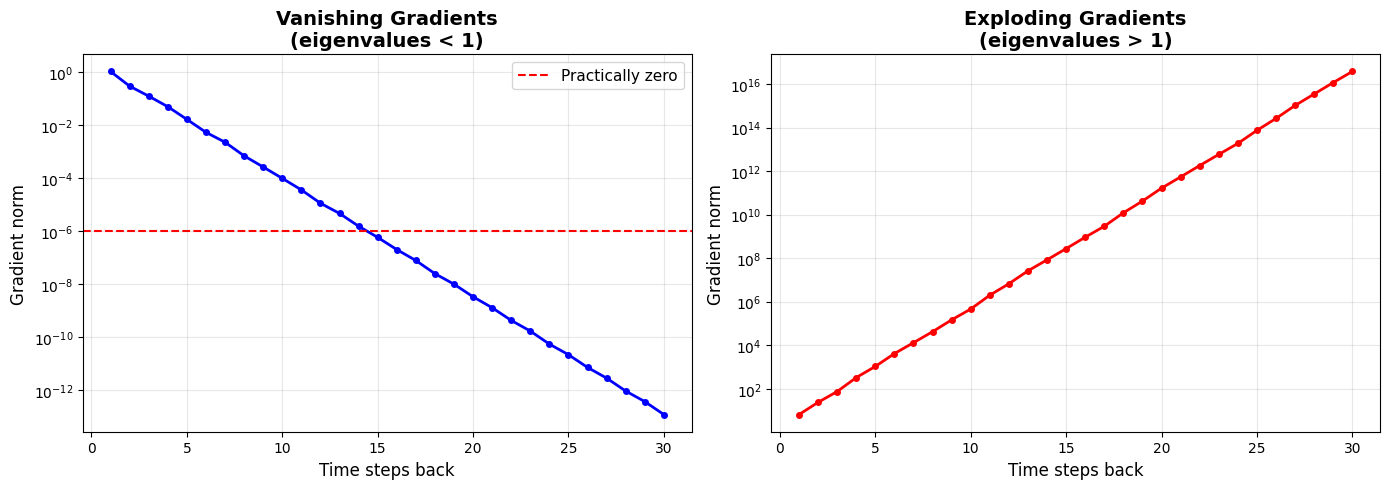

Plot saved.


In [7]:
# ============================================================
# VISUALISATION: Vanishing vs Exploding Gradients
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: vanishing gradients
axes[0].plot(range(1, 31), gradient_norms_vanish, 'b-o', markersize=4, linewidth=2)
axes[0].set_title('Vanishing Gradients\n(eigenvalues < 1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time steps back', fontsize=12)
axes[0].set_ylabel('Gradient norm', fontsize=12)
axes[0].set_yscale('log')                            # log scale to see the decay
axes[0].axhline(y=1e-6, color='r', linestyle='--', label='Practically zero')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Right plot: exploding gradients
axes[1].plot(range(1, 31), gradient_norms_explode, 'r-o', markersize=4, linewidth=2)
axes[1].set_title('Exploding Gradients\n(eigenvalues > 1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time steps back', fontsize=12)
axes[1].set_ylabel('Gradient norm', fontsize=12)
axes[1].set_yscale('log')                            # log scale to see the growth
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/anik/code/CSC5991/lecture_2/vanishing_exploding_gradients.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved.")

---
# 7. Long Short-Term Memory (LSTM) -- The Solution to Vanishing Gradients

## 7.1 The core idea

The **LSTM** (Hochreiter & Schmidhuber, 1997) introduces a **cell state** $c_t$ -- a separate
"highway" for information that can flow through many time steps with minimal modification.

Think of it like a **conveyor belt** running through the network. Information can be placed on it,
read from it, or removed from it, but it flows smoothly without being squashed by activation functions.

## 7.2 The three gates

LSTM controls the flow of information through three **gates**. Each gate is a sigmoid layer
($\sigma$) that outputs values between 0 and 1:
- **0** means "block everything" (gate is closed)
- **1** means "let everything through" (gate is open)

### Gate 1: Forget Gate $f_t$ -- "What should I forget?"

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

Decides which information in the cell state to **throw away**. For example, when we start a new
sentence, we might want to forget the subject of the previous sentence.

### Gate 2: Input Gate $i_t$ + Candidate $\tilde{c}_t$ -- "What new info should I store?"

$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{c}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)$$

- $i_t$ decides **which** values to update.
- $\tilde{c}_t$ creates a vector of **candidate** new values.

### Gate 3: Output Gate $o_t$ -- "What should I output?"

$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

Decides which parts of the cell state to **output** as the hidden state.

## 7.3 Cell state update

$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$

- $f_t \odot c_{t-1}$: keep the parts we have not "forgotten"
- $i_t \odot \tilde{c}_t$: add the new information

($\odot$ means element-wise multiplication)

## 7.4 Hidden state output

$$h_t = o_t \odot \tanh(c_t)$$

The hidden state is a filtered version of the cell state.

## 7.5 Architecture Diagram

```
                    c_{t-1}                                c_t
    ---------------------+                    +------------------------->
                         |                    |
                         v                    |
                    +---------+          +----+----+
                    |    x    |----------|    +    |
                    +----+----+          +----+----+
                         |                    |        +----------+
                    +----+----+          +----+----+   |          |
                    | f_gate  |          | i_gate  |   |  c_hat   |
                    |  sigma  |          |  sigma  |   |  tanh    |
                    +----+----+          +----+----+   +----+-----+
                         |                    |              |
    h_{t-1}--------------+--------------------+--------------+
    x_t------------------+--------------------+--------------+
                         |                                   |
                    +----+----+                          +---+----+
                    | o_gate  |    c_t --> tanh --> x -->|  h_t   |
                    |  sigma  |                     ^    +--------+
                    +---------+                     |
                                                 o_gate
```

## 7.6 Why LSTM solves vanishing gradients

The cell state $c_t$ update is:

$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$

The gradient of $c_t$ w.r.t. $c_{t-1}$ is simply $f_t$ (the forget gate). If $f_t \approx 1$,
the gradient flows through **unchanged** -- no shrinking! This is the "highway" or "shortcut"
that prevents vanishing gradients.

In [8]:
# ============================================================
# LSTM -- IMPLEMENTED FROM SCRATCH WITH NUMPY
# ============================================================
#
# Text-based architecture diagram:
#
#                  c_{t-1} ---[x f_t]---[+ i_t*c_hat]---> c_t
#                                                          |
#   x_t --+                                           [tanh]
#          +---> [f_gate sigma] ---> f_t                   |
#          +---> [i_gate sigma] ---> i_t               [x o_t] ---> h_t
#          +---> [c_gate tanh] ---> c_hat
#          +---> [o_gate sigma] ---> o_t
#   h_{t-1}+
#

class LSTM:
    '''
    Long Short-Term Memory network implemented from scratch.

    Parameters
    ----------
    input_size  : int -- dimensionality of each input vector
    hidden_size : int -- number of hidden/cell units
    output_size : int -- dimensionality of the output
    '''

    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Combined input size: we concatenate [h_{t-1}, x_t]
        concat_size = hidden_size + input_size
        scale = np.sqrt(1.0 / hidden_size)

        # -- Forget gate weights and bias --
        # f_t = sigma(W_f * [h_{t-1}, x_t] + b_f)
        self.W_f = np.random.randn(hidden_size, concat_size) * scale
        self.b_f = np.ones((hidden_size, 1))   # initialise to 1 (keep memories by default)

        # -- Input gate weights and bias --
        # i_t = sigma(W_i * [h_{t-1}, x_t] + b_i)
        self.W_i = np.random.randn(hidden_size, concat_size) * scale
        self.b_i = np.zeros((hidden_size, 1))

        # -- Candidate cell state weights and bias --
        # c_hat = tanh(W_c * [h_{t-1}, x_t] + b_c)
        self.W_c = np.random.randn(hidden_size, concat_size) * scale
        self.b_c = np.zeros((hidden_size, 1))

        # -- Output gate weights and bias --
        # o_t = sigma(W_o * [h_{t-1}, x_t] + b_o)
        self.W_o = np.random.randn(hidden_size, concat_size) * scale
        self.b_o = np.zeros((hidden_size, 1))

        # -- Output layer (hidden -> final output) --
        # y_t = softmax(W_y * h_t + b_y)
        self.W_y = np.random.randn(output_size, hidden_size) * np.sqrt(1.0 / output_size)
        self.b_y = np.zeros((output_size, 1))

        # Count total parameters
        gate_params = 4 * (hidden_size * concat_size + hidden_size)  # 4 gates
        output_params = output_size * hidden_size + output_size
        total = gate_params + output_params

        print(f"LSTM created:")
        print(f"  Input size:  {input_size}")
        print(f"  Hidden size: {hidden_size}")
        print(f"  Output size: {output_size}")
        print(f"  Gate parameters: 4 x ({hidden_size}x{concat_size} + {hidden_size}) = {gate_params}")
        print(f"  Output parameters: {output_params}")
        print(f"  Total parameters: {total}")
        print(f"  (Compare: Vanilla RNN would have ~{hidden_size*(input_size+hidden_size+1) + output_size*(hidden_size+1)} parameters)")

    @staticmethod
    def sigmoid(z):
        '''Sigmoid function: squashes values to (0, 1). Used for gates.'''
        return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))

    @staticmethod
    def tanh(z):
        '''Tanh function: squashes values to (-1, 1). Used for cell state candidate.'''
        return np.tanh(z)

    @staticmethod
    def softmax(z):
        '''Softmax: converts logits to probabilities.'''
        e_z = np.exp(z - np.max(z))
        return e_z / e_z.sum(axis=0)

    def forward(self, inputs, h_prev=None, c_prev=None):
        '''
        Forward pass through the LSTM for a sequence of inputs.

        Parameters
        ----------
        inputs : list of np.array, each (input_size, 1)
        h_prev : initial hidden state or None (defaults to zeros)
        c_prev : initial cell state or None (defaults to zeros)

        Returns
        -------
        outputs, hiddens, cells, gate_history
        '''
        T = len(inputs)

        if h_prev is None:
            h_prev = np.zeros((self.hidden_size, 1))
        if c_prev is None:
            c_prev = np.zeros((self.hidden_size, 1))

        # Storage
        outputs = []
        hiddens = [h_prev]
        cells = [c_prev]
        gate_history = {'f': [], 'i': [], 'o': [], 'c_hat': []}

        h_t = h_prev
        c_t = c_prev

        for t in range(T):
            x_t = inputs[t]   # (input_size, 1)

            # -- Step 1: Concatenate h_{t-1} and x_t --
            concat = np.vstack([h_t, x_t])   # shape: (hidden_size + input_size, 1)

            # -- Step 2: Forget gate --
            # "What old information should I discard?"
            f_t = self.sigmoid(self.W_f @ concat + self.b_f)   # (hidden_size, 1), values in (0,1)

            # -- Step 3: Input gate --
            # "What new information should I store?"
            i_t = self.sigmoid(self.W_i @ concat + self.b_i)   # (hidden_size, 1), values in (0,1)

            # -- Step 4: Candidate cell state --
            # "What are the candidate new values?"
            c_hat = self.tanh(self.W_c @ concat + self.b_c)    # (hidden_size, 1), values in (-1,1)

            # -- Step 5: Update cell state --
            # c_t = f_t * c_{t-1} + i_t * c_hat
            c_t = f_t * c_t + i_t * c_hat   # element-wise operations

            # -- Step 6: Output gate --
            # "What should I output?"
            o_t = self.sigmoid(self.W_o @ concat + self.b_o)   # (hidden_size, 1), values in (0,1)

            # -- Step 7: Hidden state (output of this cell) --
            # h_t = o_t * tanh(c_t)
            h_t = o_t * self.tanh(c_t)

            # -- Step 8: Final output (e.g., probability distribution over vocabulary) --
            z_y = self.W_y @ h_t + self.b_y
            y_hat = self.softmax(z_y)

            # Store everything
            outputs.append(y_hat)
            hiddens.append(h_t)
            cells.append(c_t)
            gate_history['f'].append(f_t)
            gate_history['i'].append(i_t)
            gate_history['o'].append(o_t)
            gate_history['c_hat'].append(c_hat)

        return outputs, hiddens, cells, gate_history


# -- Create and test the LSTM --
print("=" * 60)
print("Creating an LSTM")
print("=" * 60)
lstm = LSTM(input_size=4, hidden_size=6, output_size=4)

# Same input sequence as before
inputs = [x1, x2, x3]

print("\n" + "=" * 60)
print("Running LSTM forward pass")
print("=" * 60)

outputs_lstm, hiddens_lstm, cells_lstm, gates = lstm.forward(inputs)

for t in range(3):
    print(f"\n{'='*50}")
    print(f"  Time step t={t+1}")
    print(f"{'='*50}")
    print(f"  Input x_{t+1}:          {inputs[t].flatten()}")
    print(f"  Forget gate f_{t+1}:    {gates['f'][t].flatten().round(4)}")
    print(f"  Input gate i_{t+1}:     {gates['i'][t].flatten().round(4)}")
    print(f"  Output gate o_{t+1}:    {gates['o'][t].flatten().round(4)}")
    print(f"  Candidate c_hat_{t+1}:  {gates['c_hat'][t].flatten().round(4)}")
    print(f"  Cell state c_{t+1}:     {cells_lstm[t+1].flatten().round(4)}")
    print(f"  Hidden state h_{t+1}:   {hiddens_lstm[t+1].flatten().round(4)}")
    print(f"  Output y_{t+1}:         {outputs_lstm[t].flatten().round(4)}")
    print(f"  Sum of y_{t+1}:         {outputs_lstm[t].sum():.6f}")

Creating an LSTM
LSTM created:
  Input size:  4
  Hidden size: 6
  Output size: 4
  Gate parameters: 4 x (6x10 + 6) = 264
  Output parameters: 28
  Total parameters: 292
  (Compare: Vanilla RNN would have ~94 parameters)

Running LSTM forward pass

  Time step t=1
  Input x_1:          [1 0 0 0]
  Forget gate f_1:    [0.6587 0.7252 0.738  0.798  0.7542 0.8545]
  Input gate i_1:     [0.4965 0.4003 0.4207 0.3764 0.6817 0.5831]
  Output gate o_1:    [0.3043 0.4517 0.6265 0.6607 0.5203 0.4845]
  Candidate c_hat_1:  [ 0.0053  0.1908 -0.3459  0.2072 -0.3054  0.0262]
  Cell state c_1:     [ 0.0026  0.0764 -0.1456  0.078  -0.2082  0.0153]
  Hidden state h_1:   [ 0.0008  0.0344 -0.0905  0.0514 -0.1068  0.0074]
  Output y_1:         [0.2555 0.2578 0.2373 0.2493]
  Sum of y_1:         1.000000

  Time step t=2
  Input x_2:          [0 1 0 0]
  Forget gate f_2:    [0.7035 0.8008 0.7409 0.7516 0.7599 0.7444]
  Input gate i_2:     [0.3967 0.4148 0.4907 0.3855 0.5532 0.6647]
  Output gate o_2:    [0.

---
# 8. Gated Recurrent Unit (GRU) -- A Simpler Alternative

## 8.1 Motivation

The LSTM works great but has **a lot of parameters** (4 sets of gate weights). In 2014, Cho et al.
proposed the **GRU (Gated Recurrent Unit)** -- a simplified version with:

- Only **2 gates** instead of 3 (no separate output gate).
- **No separate cell state** -- the hidden state serves both purposes.
- Fewer parameters -> faster to train.
- Often achieves **similar performance** to LSTM.

## 8.2 The two gates

### Reset Gate $r_t$ -- "How much past info to forget"

$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$$

When $r_t \approx 0$, the candidate hidden state ignores the previous hidden state (reset).

### Update Gate $z_t$ -- "How much to update vs keep"

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$

This combines the roles of the forget and input gates from LSTM.

## 8.3 Candidate hidden state

$$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$$

Notice how $r_t$ controls how much of the previous hidden state is used.

## 8.4 Final hidden state update

$$h_t = z_t \odot h_{t-1} + (1 - z_t) \odot \tilde{h}_t$$

This is elegant: the update gate $z_t$ interpolates between keeping the old state and using the new candidate.
- If $z_t \approx 1$: keep the old hidden state (do not update).
- If $z_t \approx 0$: use the new candidate (full update).

## 8.5 Architecture Diagram

```
================================================================
                       GRU UNIT
================================================================

  h_{t-1} --+
             +---> [sigma] ---> z_t (update gate)
             +---> [sigma] ---> r_t (reset gate)
  x_t    --+        |
                     v
  [r_t * h_{t-1}, x_t] ---> [tanh] ---> h_tilde

  h_t = z_t * h_{t-1} + (1 - z_t) * h_tilde

  Only 2 gates!  No separate cell state!
================================================================
```

## 8.6 GRU vs LSTM -- Quick Comparison

| Feature | LSTM | GRU |
|---------|------|-----|
| Gates | 3 (forget, input, output) | 2 (update, reset) |
| Cell state | Yes (separate $c_t$) | No (only $h_t$) |
| Parameters | More | Fewer (~75% of LSTM) |
| Speed | Slower | Faster |
| Performance | Slightly better on very long sequences | Often comparable |

In [9]:
# ============================================================
# GRU -- IMPLEMENTED FROM SCRATCH WITH NUMPY
# ============================================================
#
# Text-based architecture:
#
#   x_t --+
#          +---> [sigma] ---> z_t (update gate: how much to update)
#          +---> [sigma] ---> r_t (reset gate: how much past to forget)
#   h_{t-1}+
#                |
#                v
#   [r_t * h_{t-1}, x_t] ---> [tanh] ---> h_tilde (candidate)
#
#   h_t = z_t * h_{t-1} + (1 - z_t) * h_tilde   (interpolate old & new)

class GRU:
    '''
    Gated Recurrent Unit implemented from scratch.

    Parameters
    ----------
    input_size  : int -- dimensionality of each input vector
    hidden_size : int -- number of hidden units
    output_size : int -- dimensionality of the output
    '''

    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        concat_size = hidden_size + input_size
        scale = np.sqrt(1.0 / hidden_size)

        # -- Update gate (z): combines forget + input gate from LSTM --
        self.W_z = np.random.randn(hidden_size, concat_size) * scale
        self.b_z = np.zeros((hidden_size, 1))

        # -- Reset gate (r): controls how much past to forget --
        self.W_r = np.random.randn(hidden_size, concat_size) * scale
        self.b_r = np.zeros((hidden_size, 1))

        # -- Candidate hidden state --
        self.W_h = np.random.randn(hidden_size, concat_size) * scale
        self.b_h = np.zeros((hidden_size, 1))

        # -- Output layer --
        self.W_y = np.random.randn(output_size, hidden_size) * np.sqrt(1.0 / output_size)
        self.b_y = np.zeros((output_size, 1))

        # Count parameters
        gate_params = 3 * (hidden_size * concat_size + hidden_size)  # 3 weight matrices (z, r, h)
        output_params = output_size * hidden_size + output_size
        total = gate_params + output_params

        print(f"GRU created:")
        print(f"  Input size:  {input_size}")
        print(f"  Hidden size: {hidden_size}")
        print(f"  Output size: {output_size}")
        print(f"  Total parameters: {total}")

    @staticmethod
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))

    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def softmax(z):
        e_z = np.exp(z - np.max(z))
        return e_z / e_z.sum(axis=0)

    def forward(self, inputs, h_prev=None):
        '''
        Forward pass through the GRU for a sequence of inputs.

        Returns outputs, hiddens, gate_history
        '''
        T = len(inputs)

        if h_prev is None:
            h_prev = np.zeros((self.hidden_size, 1))

        outputs = []
        hiddens = [h_prev]
        gate_history = {'z': [], 'r': [], 'h_hat': []}

        h_t = h_prev

        for t in range(T):
            x_t = inputs[t]

            # -- Step 1: Concatenate h_{t-1} and x_t --
            concat = np.vstack([h_t, x_t])

            # -- Step 2: Update gate --
            # "How much of the old state to keep vs how much to update?"
            z_t = self.sigmoid(self.W_z @ concat + self.b_z)

            # -- Step 3: Reset gate --
            # "How much of the past to forget when computing candidate?"
            r_t = self.sigmoid(self.W_r @ concat + self.b_r)

            # -- Step 4: Candidate hidden state --
            # The reset gate r_t filters h_{t-1} before using it
            concat_reset = np.vstack([r_t * h_t, x_t])   # r_t * h_{t-1} instead of just h_{t-1}
            h_hat = self.tanh(self.W_h @ concat_reset + self.b_h)

            # -- Step 5: Interpolate between old and new --
            # h_t = z_t * h_{t-1} + (1 - z_t) * h_tilde
            h_t = z_t * hiddens[-1] + (1 - z_t) * h_hat

            # -- Step 6: Output --
            z_y = self.W_y @ h_t + self.b_y
            y_hat = self.softmax(z_y)

            outputs.append(y_hat)
            hiddens.append(h_t)
            gate_history['z'].append(z_t)
            gate_history['r'].append(r_t)
            gate_history['h_hat'].append(h_hat)

        return outputs, hiddens, gate_history


# -- Create and test the GRU --
print("=" * 60)
print("Creating a GRU")
print("=" * 60)
gru = GRU(input_size=4, hidden_size=6, output_size=4)

print("\n" + "=" * 60)
print("Running GRU forward pass")
print("=" * 60)

outputs_gru, hiddens_gru, gates_gru = gru.forward(inputs)

for t in range(3):
    print(f"\n{'='*50}")
    print(f"  Time step t={t+1}")
    print(f"{'='*50}")
    print(f"  Input x_{t+1}:            {inputs[t].flatten()}")
    print(f"  Update gate z_{t+1}:      {gates_gru['z'][t].flatten().round(4)}")
    print(f"  Reset gate r_{t+1}:       {gates_gru['r'][t].flatten().round(4)}")
    print(f"  Candidate h_hat_{t+1}:   {gates_gru['h_hat'][t].flatten().round(4)}")
    print(f"  Hidden state h_{t+1}:     {hiddens_gru[t+1].flatten().round(4)}")
    print(f"  Output y_{t+1}:          {outputs_gru[t].flatten().round(4)}")

Creating a GRU
GRU created:
  Input size:  4
  Hidden size: 6
  Output size: 4
  Total parameters: 226

Running GRU forward pass

  Time step t=1
  Input x_1:            [1 0 0 0]
  Update gate z_1:      [0.5099 0.4988 0.4169 0.5317 0.5528 0.5025]
  Reset gate r_1:       [0.4151 0.4093 0.3428 0.5721 0.6987 0.3815]
  Candidate h_hat_1:   [ 0.1555 -0.0256  0.6652 -0.1118 -0.0522 -0.0033]
  Hidden state h_1:     [ 0.0762 -0.0128  0.3879 -0.0524 -0.0233 -0.0016]
  Output y_1:          [0.2485 0.2193 0.2862 0.2461]

  Time step t=2
  Input x_2:            [0 1 0 0]
  Update gate z_2:      [0.5975 0.4425 0.5008 0.5973 0.6527 0.565 ]
  Reset gate r_2:       [0.4851 0.5453 0.3762 0.3444 0.7237 0.2697]
  Candidate h_hat_2:   [ 0.1274  0.3807  0.0139 -0.7192 -0.3398  0.5039]
  Hidden state h_2:     [ 0.0968  0.2066  0.2012 -0.3209 -0.1332  0.2182]
  Output y_2:          [0.2665 0.2769 0.2757 0.1809]

  Time step t=3
  Input x_3:            [0 0 1 0]
  Update gate z_3:      [0.4469 0.4756 0.5069 

---
# 9. BIG Comparison: Vanilla RNN vs LSTM vs GRU

| Feature | Vanilla RNN | LSTM | GRU |
|---------|-------------|------|-----|
| **Year introduced** | ~1986 (Elman network) | 1997 (Hochreiter & Schmidhuber) | 2014 (Cho et al.) |
| **Number of gates** | 0 | 3 (forget, input, output) | 2 (update, reset) |
| **Cell state** | No (only hidden state $h_t$) | Yes ($c_t$ separate from $h_t$) | No (only hidden state $h_t$) |
| **Hidden state equation** | $h_t = \tanh(V x_t + W h_{t-1} + b)$ | $h_t = o_t \odot \tanh(c_t)$ | $h_t = z_t \odot h_{t-1} + (1-z_t) \odot \tilde{h}_t$ |
| **Parameters (approx.)** | $d_h(d_{in} + d_h + 1)$ | $4 \times d_h(d_{in} + d_h + 1)$ | $3 \times d_h(d_{in} + d_h + 1)$ |
| **Parameter ratio** | 1x (baseline) | ~4x of RNN | ~3x of RNN |
| **Training speed** | Fastest | Slowest | Medium |
| **Vanishing gradient?** | YES (major problem) | No (cell state highway) | No (update gate interpolation) |
| **Long-range dependencies** | Poor (cannot learn beyond ~10 steps) | Excellent | Very good |
| **Memory mechanism** | Single hidden state, overwritten each step | Dual: cell state (long-term) + hidden state (short-term) | Single hidden state with gated interpolation |
| **Computational cost** | Low | High (4 matrix multiplies per step) | Medium (3 matrix multiplies per step) |
| **When to use** | Very short sequences, toy problems | Long sequences, complex dependencies, when you need the best accuracy | Medium-length sequences, when you need speed + good accuracy |
| **Real-world analogy** | Writing on a whiteboard -- each new thing partially erases the old | Filing cabinet -- organised long-term storage with controlled access | Notebook with selective erasing -- simpler than a filing cabinet |
| **Pros** | Simple, fast, easy to understand | Best at long sequences, most studied | Fewer parameters, faster than LSTM, often similar performance |
| **Cons** | Vanishing gradients, poor long-term memory | Slow, many parameters, complex | Slightly less powerful than LSTM on very long sequences |
| **Famous uses** | Simple sequence classification | Machine translation, speech recognition, time series | Similar to LSTM, popular in newer research |

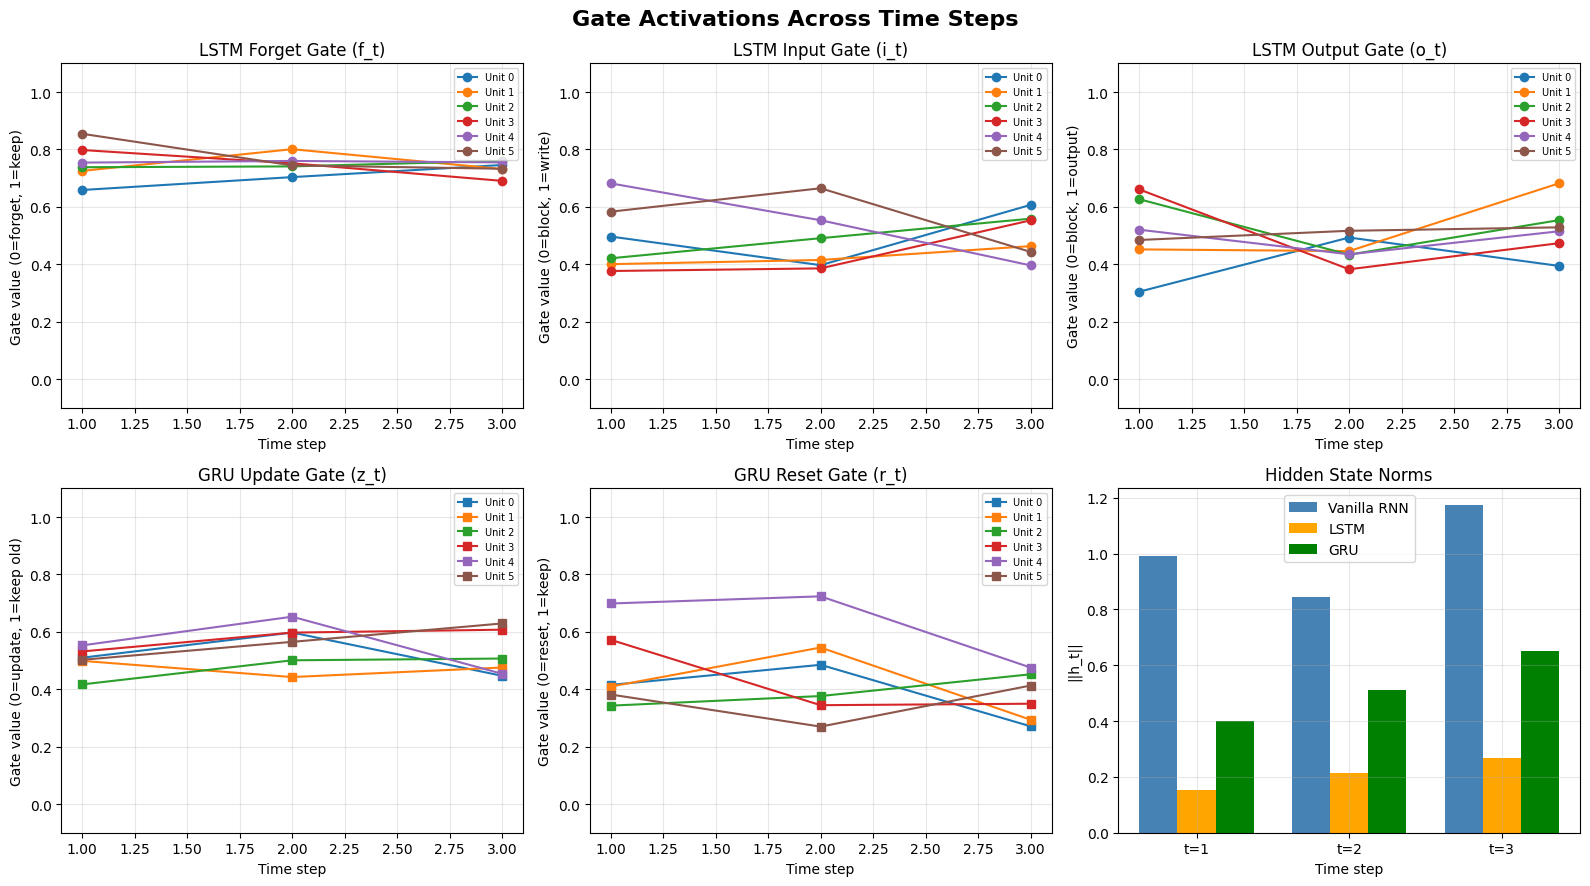

Plot saved.


In [10]:
# ============================================================
# VISUALISATION: Gate Activations (LSTM and GRU)
# ============================================================
# Let's see how the gates behave across time steps.

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Gate Activations Across Time Steps', fontsize=16, fontweight='bold')

# -- LSTM gates --
# Forget gate
for unit in range(6):
    vals = [gates['f'][t][unit, 0] for t in range(3)]
    axes[0, 0].plot(range(1, 4), vals, 'o-', label=f'Unit {unit}')
axes[0, 0].set_title('LSTM Forget Gate (f_t)')
axes[0, 0].set_xlabel('Time step')
axes[0, 0].set_ylabel('Gate value (0=forget, 1=keep)')
axes[0, 0].set_ylim(-0.1, 1.1)
axes[0, 0].legend(fontsize=7)
axes[0, 0].grid(True, alpha=0.3)

# Input gate
for unit in range(6):
    vals = [gates['i'][t][unit, 0] for t in range(3)]
    axes[0, 1].plot(range(1, 4), vals, 'o-', label=f'Unit {unit}')
axes[0, 1].set_title('LSTM Input Gate (i_t)')
axes[0, 1].set_xlabel('Time step')
axes[0, 1].set_ylabel('Gate value (0=block, 1=write)')
axes[0, 1].set_ylim(-0.1, 1.1)
axes[0, 1].legend(fontsize=7)
axes[0, 1].grid(True, alpha=0.3)

# Output gate
for unit in range(6):
    vals = [gates['o'][t][unit, 0] for t in range(3)]
    axes[0, 2].plot(range(1, 4), vals, 'o-', label=f'Unit {unit}')
axes[0, 2].set_title('LSTM Output Gate (o_t)')
axes[0, 2].set_xlabel('Time step')
axes[0, 2].set_ylabel('Gate value (0=block, 1=output)')
axes[0, 2].set_ylim(-0.1, 1.1)
axes[0, 2].legend(fontsize=7)
axes[0, 2].grid(True, alpha=0.3)

# -- GRU gates --
# Update gate
for unit in range(6):
    vals = [gates_gru['z'][t][unit, 0] for t in range(3)]
    axes[1, 0].plot(range(1, 4), vals, 's-', label=f'Unit {unit}')
axes[1, 0].set_title('GRU Update Gate (z_t)')
axes[1, 0].set_xlabel('Time step')
axes[1, 0].set_ylabel('Gate value (0=update, 1=keep old)')
axes[1, 0].set_ylim(-0.1, 1.1)
axes[1, 0].legend(fontsize=7)
axes[1, 0].grid(True, alpha=0.3)

# Reset gate
for unit in range(6):
    vals = [gates_gru['r'][t][unit, 0] for t in range(3)]
    axes[1, 1].plot(range(1, 4), vals, 's-', label=f'Unit {unit}')
axes[1, 1].set_title('GRU Reset Gate (r_t)')
axes[1, 1].set_xlabel('Time step')
axes[1, 1].set_ylabel('Gate value (0=reset, 1=keep)')
axes[1, 1].set_ylim(-0.1, 1.1)
axes[1, 1].legend(fontsize=7)
axes[1, 1].grid(True, alpha=0.3)

# Hidden state norms comparison
rnn_norms = [np.linalg.norm(hiddens[t]) for t in range(3)]
lstm_norms = [np.linalg.norm(hiddens_lstm[t+1]) for t in range(3)]
gru_norms = [np.linalg.norm(hiddens_gru[t+1]) for t in range(3)]

bar_width = 0.25
x_pos = np.arange(3)
axes[1, 2].bar(x_pos - bar_width, rnn_norms, bar_width, label='Vanilla RNN', color='steelblue')
axes[1, 2].bar(x_pos, lstm_norms, bar_width, label='LSTM', color='orange')
axes[1, 2].bar(x_pos + bar_width, gru_norms, bar_width, label='GRU', color='green')
axes[1, 2].set_title('Hidden State Norms')
axes[1, 2].set_xlabel('Time step')
axes[1, 2].set_ylabel('||h_t||')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(['t=1', 't=2', 't=3'])
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/anik/code/CSC5991/lecture_2/gate_activations.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved.")

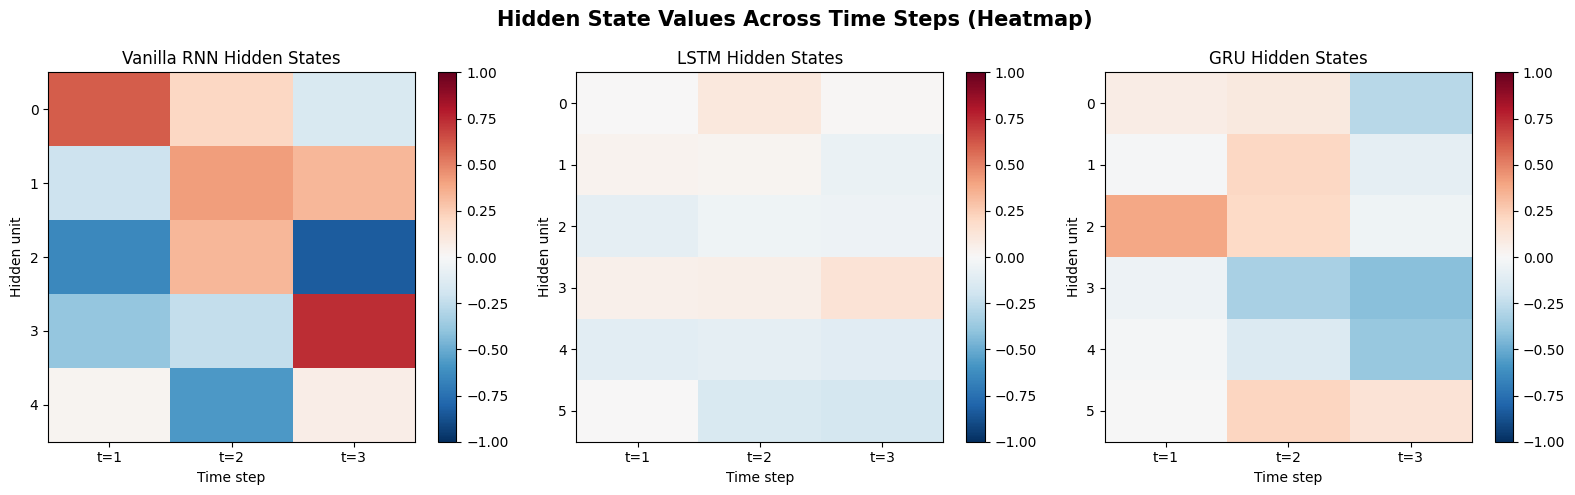

Plot saved.


In [11]:
# ============================================================
# VISUALISATION: Hidden State Evolution (Heatmaps)
# ============================================================
# Let's see how the hidden state values change over time for each model.

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Hidden State Values Across Time Steps (Heatmap)', fontsize=15, fontweight='bold')

# Vanilla RNN hidden states
rnn_h_matrix = np.hstack([hiddens[t] for t in range(3)])  # (hidden_size, T)
im0 = axes[0].imshow(rnn_h_matrix, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_title('Vanilla RNN Hidden States')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('Hidden unit')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['t=1', 't=2', 't=3'])
plt.colorbar(im0, ax=axes[0])

# LSTM hidden states
lstm_h_matrix = np.hstack([hiddens_lstm[t+1] for t in range(3)])
im1 = axes[1].imshow(lstm_h_matrix, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
axes[1].set_title('LSTM Hidden States')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Hidden unit')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['t=1', 't=2', 't=3'])
plt.colorbar(im1, ax=axes[1])

# GRU hidden states
gru_h_matrix = np.hstack([hiddens_gru[t+1] for t in range(3)])
im2 = axes[2].imshow(gru_h_matrix, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
axes[2].set_title('GRU Hidden States')
axes[2].set_xlabel('Time step')
axes[2].set_ylabel('Hidden unit')
axes[2].set_xticks([0, 1, 2])
axes[2].set_xticklabels(['t=1', 't=2', 't=3'])
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig('/home/anik/code/CSC5991/lecture_2/hidden_states_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved.")

---
# 10. Practical Example: Character-Level Language Model

Now let us put everything together and build a **working character-level language model** using our
Vanilla RNN. This model will:

1. Read a text string character by character.
2. Learn to predict the **next character** given the previous ones.
3. After training, generate new text character by character.

## How it works

1. **Vocabulary:** Every unique character in our training text (e.g., `a`, `b`, `c`, ... , `z`, ` `).
2. **Input encoding:** Each character is converted to a **one-hot vector** (a vector of all zeros with a single 1 at the character's index).
3. **Training:** At each time step, the RNN sees one character and tries to predict the next one.
4. **Generation:** Start with a seed character, predict the next, feed it back in, repeat.

This is the simplest possible language model -- the same idea behind GPT, just with characters instead
of sub-word tokens and an RNN instead of a Transformer!

In [12]:
# ============================================================
# CHARACTER-LEVEL LANGUAGE MODEL -- USING VANILLA RNN
# ============================================================
# We'll train a tiny RNN to learn patterns in a small text.

# -- Training text --
# We use a repetitive text so a tiny network can learn the patterns
training_text = "hello world hello world hello world hello world hello world "
print(f"Training text: '{training_text}'")
print(f"Length: {len(training_text)} characters")

# -- Step 1: Build the vocabulary --
# Find all unique characters and assign each an index number
chars = sorted(list(set(training_text)))   # unique characters, sorted
vocab_size = len(chars)                     # how many unique characters
char_to_idx = {ch: i for i, ch in enumerate(chars)}   # character -> number
idx_to_char = {i: ch for i, ch in enumerate(chars)}   # number -> character

print(f"\nVocabulary ({vocab_size} unique characters):")
for ch, idx in char_to_idx.items():
    display_ch = repr(ch)  # shows space as "' '"
    print(f"  {display_ch:>5} -> {idx}")

# -- Step 2: Encode the text as one-hot vectors --
def char_to_onehot(ch):
    '''Convert a character to a one-hot column vector.'''
    vec = np.zeros((vocab_size, 1))       # all zeros
    vec[char_to_idx[ch]] = 1.0            # set the correct position to 1
    return vec

# Example
print(f"\nOne-hot encoding of 'h': {char_to_onehot('h').flatten()}")
print(f"One-hot encoding of 'e': {char_to_onehot('e').flatten()}")

# -- Step 3: Create training pairs (input -> target) --
# Input:  h e l l o   w o r l d   h e l l o  ...
# Target: e l l o   w o r l d   h e l l o    ...
# (each target is the NEXT character)

inputs_text = training_text[:-1]    # all characters except the last
targets_text = training_text[1:]    # all characters except the first

print(f"\nInput:  '{inputs_text[:20]}...'")
print(f"Target: '{targets_text[:20]}...'")
print(f"Training pairs: {len(inputs_text)}")

Training text: 'hello world hello world hello world hello world hello world '
Length: 60 characters

Vocabulary (8 unique characters):
    ' ' -> 0
    'd' -> 1
    'e' -> 2
    'h' -> 3
    'l' -> 4
    'o' -> 5
    'r' -> 6
    'w' -> 7

One-hot encoding of 'h': [0. 0. 0. 1. 0. 0. 0. 0.]
One-hot encoding of 'e': [0. 0. 1. 0. 0. 0. 0. 0.]

Input:  'hello world hello wo...'
Target: 'ello world hello wor...'
Training pairs: 59


In [13]:
# ============================================================
# TRAINING THE CHARACTER-LEVEL RNN
# ============================================================

# -- Hyperparameters --
hidden_size = 32         # number of hidden units
learning_rate = 0.01     # how big each weight update is
num_epochs = 200         # how many times to go through the data
seq_length = 10          # process sequences of this length at a time

print(f"Hyperparameters:")
print(f"  Vocabulary size : {vocab_size}")
print(f"  Hidden size     : {hidden_size}")
print(f"  Learning rate   : {learning_rate}")
print(f"  Epochs          : {num_epochs}")
print(f"  Sequence length : {seq_length}")

# -- Create the RNN --
# We reuse our VanillaRNN class from earlier
char_rnn = VanillaRNN(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size)

# -- Training loop --
losses = []   # track loss over time

for epoch in range(num_epochs):
    epoch_loss = 0.0
    h = np.zeros((hidden_size, 1))   # reset hidden state each epoch

    # Process the text in chunks of seq_length
    for start in range(0, len(inputs_text) - seq_length, seq_length):
        # Prepare input and target sequences for this chunk
        inp_seq = [char_to_onehot(inputs_text[start + t]) for t in range(seq_length)]
        tgt_seq = [char_to_onehot(targets_text[start + t]) for t in range(seq_length)]

        # Forward pass
        outputs_char, hiddens_char, cache_char = char_rnn.forward(inp_seq, h_prev=h)

        # Use the last hidden state for the next chunk (carry state forward)
        h = hiddens_char[-1]

        # Backward pass (compute gradients)
        grads_char, chunk_loss = rnn_backward(char_rnn, cache_char, tgt_seq)
        epoch_loss += chunk_loss

        # -- Gradient descent: update weights --
        # W_new = W_old - learning_rate * gradient
        char_rnn.V -= learning_rate * grads_char['dV']
        char_rnn.W -= learning_rate * grads_char['dW']
        char_rnn.U -= learning_rate * grads_char['dU']
        char_rnn.b_h -= learning_rate * grads_char['db_h']
        char_rnn.b_y -= learning_rate * grads_char['db_y']

    losses.append(epoch_loss)

    # Print progress every 20 epochs
    if epoch % 20 == 0 or epoch == num_epochs - 1:
        print(f"  Epoch {epoch:>4d}/{num_epochs}  Loss: {epoch_loss:.4f}")

print("\nTraining complete!")

Hyperparameters:
  Vocabulary size : 8
  Hidden size     : 32
  Learning rate   : 0.01
  Epochs          : 200
  Sequence length : 10
VanillaRNN created:
  Input size  (d_in)  = 8
  Hidden size (d_h)   = 32
  Output size (d_out) = 8
  V shape: (32, 8)  (input -> hidden)
  W shape: (32, 32)  (hidden -> hidden)
  U shape: (8, 32)  (hidden -> output)
  b_h shape: (32, 1)
  b_y shape: (8, 1)
  Total learnable parameters: 1576
  Epoch    0/200  Loss: 90.1300
  Epoch   20/200  Loss: 2.4901
  Epoch   40/200  Loss: 1.1570
  Epoch   60/200  Loss: 0.7312
  Epoch   80/200  Loss: 0.5297


  Epoch  100/200  Loss: 0.4139


  Epoch  120/200  Loss: 0.3392
  Epoch  140/200  Loss: 0.2871
  Epoch  160/200  Loss: 0.2487
  Epoch  180/200  Loss: 0.2193
  Epoch  199/200  Loss: 0.1971

Training complete!


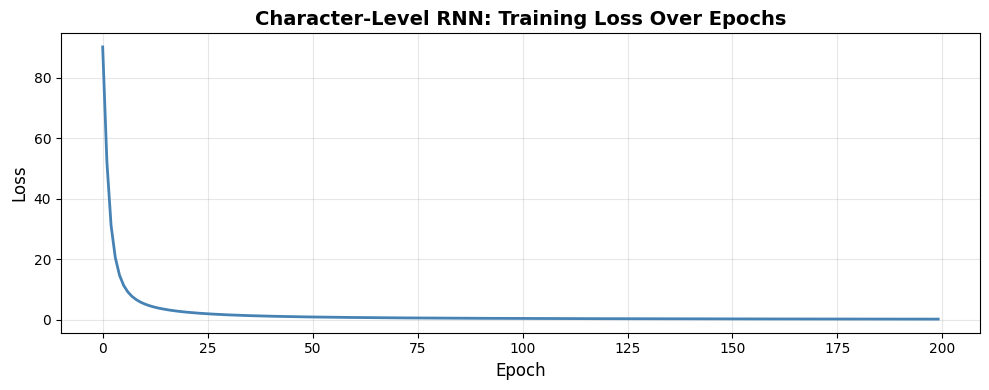

The loss should decrease over time as the model learns!


In [14]:
# ============================================================
# PLOT: Training Loss Over Epochs
# ============================================================

plt.figure(figsize=(10, 4))
plt.plot(losses, linewidth=2, color='steelblue')
plt.title('Character-Level RNN: Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/anik/code/CSC5991/lecture_2/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()
print("The loss should decrease over time as the model learns!")

In [15]:
# ============================================================
# TEXT GENERATION -- Sample from the trained RNN
# ============================================================

def generate_text(rnn, seed_char, length=50, temperature=1.0):
    '''
    Generate text character by character using the trained RNN.

    Parameters
    ----------
    rnn         : VanillaRNN -- trained model
    seed_char   : str -- starting character
    length      : int -- how many characters to generate
    temperature : float -- controls randomness (lower = more deterministic)

    Returns
    -------
    generated : str -- the generated text
    '''
    h = np.zeros((rnn.hidden_size, 1))   # start with zero hidden state
    x = char_to_onehot(seed_char)         # one-hot encode the seed
    generated = seed_char                  # start building the output string

    for _ in range(length):
        # Forward pass for one time step
        outputs_gen, hiddens_gen, _ = rnn.forward([x], h_prev=h)
        h = hiddens_gen[-1]                # update hidden state

        # Get the probability distribution
        probs = outputs_gen[0].flatten()   # shape: (vocab_size,)

        # Apply temperature (higher = more random, lower = more greedy)
        probs = np.exp(np.log(probs + 1e-12) / temperature)
        probs = probs / probs.sum()        # re-normalise

        # Sample the next character from the distribution
        next_idx = np.random.choice(range(vocab_size), p=probs)
        next_char = idx_to_char[next_idx]

        generated += next_char
        x = char_to_onehot(next_char)      # feed the generated char back as input

    return generated

# -- Generate text with different temperatures --
print("=" * 60)
print("TEXT GENERATION FROM TRAINED RNN")
print("=" * 60)

for temp in [0.5, 0.8, 1.0, 1.5]:
    print(f"\nTemperature = {temp}:")
    for trial in range(3):
        text = generate_text(char_rnn, seed_char='h', length=40, temperature=temp)
        print(f"  Trial {trial+1}: '{text}'")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("- Low temperature (0.5): More repetitive/predictable (the model picks")
print("  the most likely character each time)")
print("- High temperature (1.5): More random/creative (the model explores")
print("  less likely characters)")
print("- Our tiny RNN learned the 'hello world' pattern from just ~60 characters!")

TEXT GENERATION FROM TRAINED RNN

Temperature = 0.5:
  Trial 1: 'hello world hello world hello world hello'
  Trial 2: 'hello world hello world hello world hello'
  Trial 3: 'hello world hello world hello world hello'

Temperature = 0.8:
  Trial 1: 'hollo world hello world hello world hello'
  Trial 2: 'hello world hello world hello world hello'
  Trial 3: 'hello world hello world hello world hello'

Temperature = 1.0:
  Trial 1: 'hello world hello world hello world hello'
  Trial 2: 'hello w rld helld world hello world hello'
  Trial 3: 'hello world hello world hello world hello'

Temperature = 1.5:
  Trial 1: 'he lo worle hello world hello woeld hello'
  Trial 2: 'hello world hello worll hello world hello'
  Trial 3: 'hello world hello world hello woeld hello'

INTERPRETATION
- Low temperature (0.5): More repetitive/predictable (the model picks
  the most likely character each time)
- High temperature (1.5): More random/creative (the model explores
  less likely characters)
- Our tin

---
# 11. Gradient Flow Comparison: RNN vs LSTM

Let us empirically demonstrate **why LSTM is better than Vanilla RNN for long sequences**.

We will create a long sequence and measure how the gradient magnitude changes as we backpropagate
further and further back in time. In a Vanilla RNN, the gradient will shrink (vanish). In an LSTM,
the gradient will remain stable thanks to the cell state "highway".

In [16]:
# ============================================================
# EXPERIMENT: Gradient Flow -- RNN vs LSTM over long sequences
# ============================================================
# We pass a long sequence through both models and measure
# the gradient at each time step during backpropagation.

np.random.seed(123)

sequence_length = 50   # 50 time steps -- long enough to see vanishing
input_dim = 4
hidden_dim = 8

# -- Generate random input sequence --
long_inputs = [np.random.randn(input_dim, 1) * 0.5 for _ in range(sequence_length)]
long_targets = [np.zeros((input_dim, 1)) for _ in range(sequence_length)]
for tgt in long_targets:
    tgt[np.random.randint(input_dim)] = 1.0   # random one-hot targets

# -- Vanilla RNN: measure gradient at each time step --
rnn_test = VanillaRNN(input_size=input_dim, hidden_size=hidden_dim, output_size=input_dim)
outputs_r, hiddens_r, cache_r = rnn_test.forward(long_inputs)

# Manual BPTT tracking gradients at each step
dh_next = np.zeros((hidden_dim, 1))
rnn_grad_norms = []

for t in reversed(range(sequence_length)):
    y_hat = cache_r['outputs'][t]
    h_t = cache_r['hiddens'][t + 1]
    h_prev = cache_r['hiddens'][t]
    x_t = cache_r['inputs'][t]
    target_idx = np.argmax(long_targets[t])

    dy = y_hat.copy()
    dy[target_idx] -= 1.0

    dh = rnn_test.U.T @ dy + dh_next
    dz_h = dh * (1 - h_t ** 2)
    dh_next = rnn_test.W.T @ dz_h

    rnn_grad_norms.append(np.linalg.norm(dh_next))

rnn_grad_norms.reverse()   # reverse so index 0 = time step 0

# -- LSTM: measure gradient at each time step --
lstm_test = LSTM(input_size=input_dim, hidden_size=hidden_dim, output_size=input_dim)
outputs_l, hiddens_l, cells_l, gates_l = lstm_test.forward(long_inputs)

# For LSTM, we track the gradient through the cell state
# The key insight: dc_{t}/dc_{t-1} = f_t (forget gate), which can stay close to 1
lstm_grad_norms = []
dc_next = np.zeros((hidden_dim, 1))
dh_next_l = np.zeros((hidden_dim, 1))

for t in reversed(range(sequence_length)):
    y_hat = outputs_l[t]
    target_idx = np.argmax(long_targets[t])

    dy = y_hat.copy()
    dy[target_idx] -= 1.0

    dh = lstm_test.W_y.T @ dy + dh_next_l

    h_t = hiddens_l[t + 1]
    c_t = cells_l[t + 1]
    c_prev = cells_l[t]

    f_t = gates_l['f'][t]
    i_t = gates_l['i'][t]
    o_t = gates_l['o'][t]
    c_hat = gates_l['c_hat'][t]

    # Gradient through output gate and tanh
    do = dh * np.tanh(c_t)
    dc = dh * o_t * (1 - np.tanh(c_t) ** 2) + dc_next

    # Gradient through cell state update
    dc_prev = dc * f_t      # THIS is why LSTM works: multiplied by f_t ~ 1
    dc_next = dc_prev

    # Gradient flowing back to hidden state
    concat = np.vstack([hiddens_l[t], long_inputs[t]])
    df = dc * c_prev * f_t * (1 - f_t)
    di = dc * c_hat * i_t * (1 - i_t)
    dc_hat = dc * i_t * (1 - c_hat ** 2)
    do_g = do * o_t * (1 - o_t)

    dh_next_l = (lstm_test.W_f[:, :hidden_dim].T @ df +
                 lstm_test.W_i[:, :hidden_dim].T @ di +
                 lstm_test.W_c[:, :hidden_dim].T @ dc_hat +
                 lstm_test.W_o[:, :hidden_dim].T @ do_g)

    lstm_grad_norms.append(np.linalg.norm(dh_next_l) + np.linalg.norm(dc_next))

lstm_grad_norms.reverse()

print("Gradient norms computed for both RNN and LSTM over 50 time steps.")
print(f"\nVanilla RNN gradient at step 0 (earliest): {rnn_grad_norms[0]:.2e}")
print(f"Vanilla RNN gradient at step 49 (latest):  {rnn_grad_norms[-1]:.2e}")
print(f"LSTM gradient at step 0 (earliest):         {lstm_grad_norms[0]:.2e}")
print(f"LSTM gradient at step 49 (latest):          {lstm_grad_norms[-1]:.2e}")

VanillaRNN created:
  Input size  (d_in)  = 4
  Hidden size (d_h)   = 8
  Output size (d_out) = 4
  V shape: (8, 4)  (input -> hidden)
  W shape: (8, 8)  (hidden -> hidden)
  U shape: (4, 8)  (hidden -> output)
  b_h shape: (8, 1)
  b_y shape: (4, 1)
  Total learnable parameters: 140
LSTM created:
  Input size:  4
  Hidden size: 8
  Output size: 4
  Gate parameters: 4 x (8x12 + 8) = 416
  Output parameters: 36
  Total parameters: 452
  (Compare: Vanilla RNN would have ~140 parameters)
Gradient norms computed for both RNN and LSTM over 50 time steps.

Vanilla RNN gradient at step 0 (earliest): 1.12e+00
Vanilla RNN gradient at step 49 (latest):  9.85e-01
LSTM gradient at step 0 (earliest):         8.80e-01
LSTM gradient at step 49 (latest):          5.58e-01


/tmp/ipykernel_296068/812067903.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


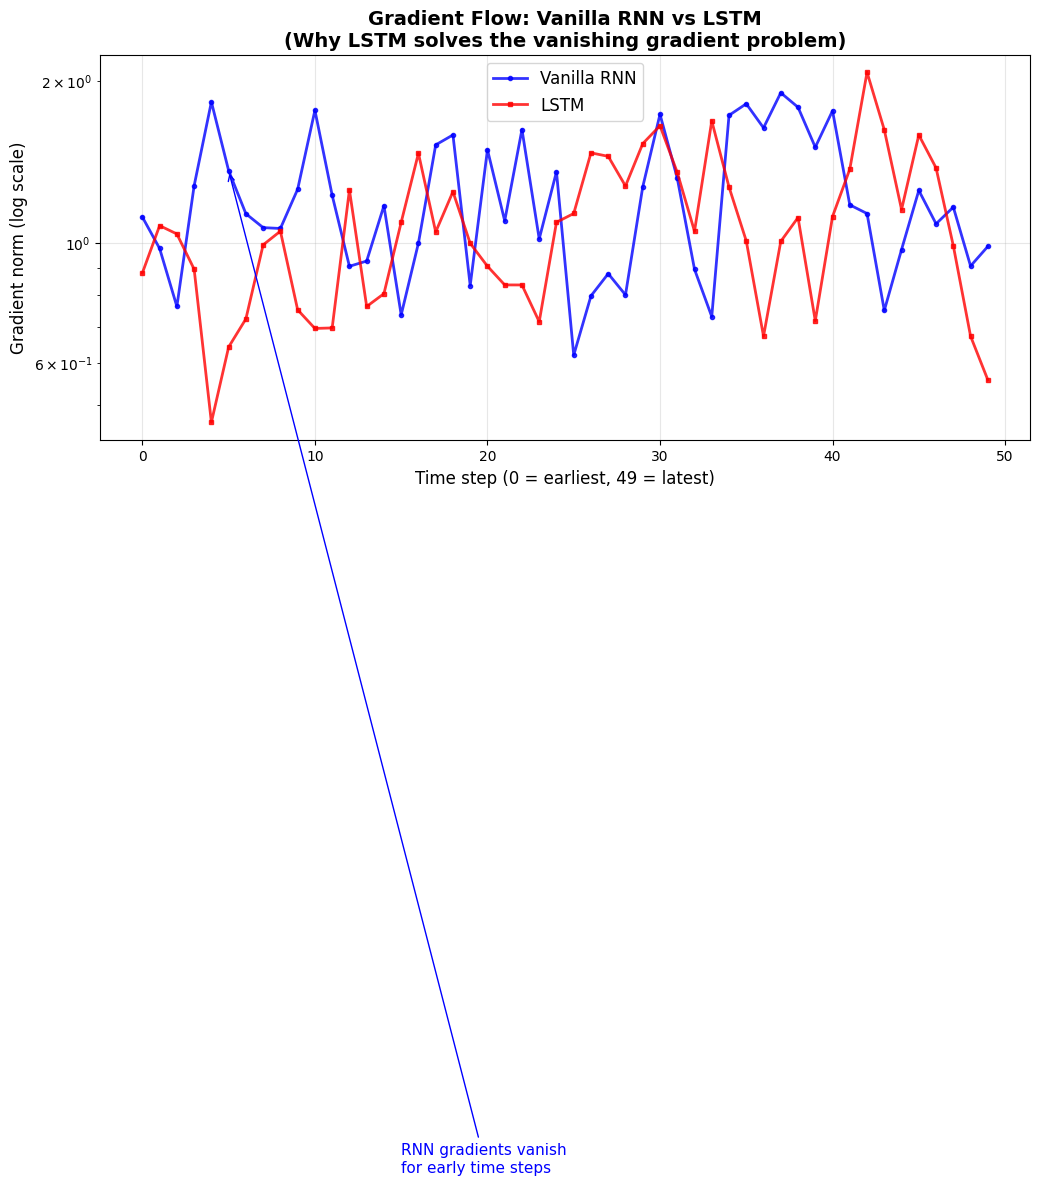

This plot clearly shows:
  - Vanilla RNN: gradient VANISHES for early time steps (cannot learn long dependencies)
  - LSTM: gradient remains STABLE across all time steps (can learn long dependencies)


In [17]:
# ============================================================
# PLOT: Gradient Flow -- RNN vs LSTM
# ============================================================

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(range(sequence_length), rnn_grad_norms, 'b-o', markersize=3,
        linewidth=2, label='Vanilla RNN', alpha=0.8)
ax.plot(range(sequence_length), lstm_grad_norms, 'r-s', markersize=3,
        linewidth=2, label='LSTM', alpha=0.8)

ax.set_title('Gradient Flow: Vanilla RNN vs LSTM\n(Why LSTM solves the vanishing gradient problem)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Time step (0 = earliest, 49 = latest)', fontsize=12)
ax.set_ylabel('Gradient norm (log scale)', fontsize=12)
ax.set_yscale('log')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add annotation
ax.annotate('RNN gradients vanish\nfor early time steps',
            xy=(5, rnn_grad_norms[5] if rnn_grad_norms[5] > 0 else 1e-15),
            xytext=(15, max(rnn_grad_norms) * 0.01),
            fontsize=11, color='blue',
            arrowprops=dict(arrowstyle='->', color='blue'))

plt.tight_layout()
plt.savefig('/home/anik/code/CSC5991/lecture_2/gradient_flow_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("This plot clearly shows:")
print("  - Vanilla RNN: gradient VANISHES for early time steps (cannot learn long dependencies)")
print("  - LSTM: gradient remains STABLE across all time steps (can learn long dependencies)")

---
# 12. Real-World Analogies

Understanding these architectures through everyday analogies can make the concepts click.

## Vanilla RNN -- The Goldfish Memory

Imagine you are a **goldfish** trying to remember a conversation. You can remember what was *just said*
(the last few words), but anything from the beginning of the conversation is completely forgotten.

- **Hidden state** $h_t$ = the goldfish's current memory (short-term only).
- **Problem:** By the time you hear the end of a long sentence, you have forgotten the beginning.

## LSTM -- The Filing Cabinet

Now imagine you have a **filing cabinet** (the cell state $c_t$) in addition to your short-term memory.

- **Forget gate** $f_t$ = "Which files should I throw away?" (spring cleaning).
- **Input gate** $i_t$ = "Which new documents should I file away?" (selective storage).
- **Output gate** $o_t$ = "Which files do I need to pull out right now?" (selective retrieval).
- **Cell state** $c_t$ = The actual filing cabinet (long-term storage).
- **Hidden state** $h_t$ = What you are currently looking at from the cabinet.

The filing cabinet persists over time -- you do not lose old files unless you explicitly choose to
discard them (forget gate). This is why LSTM can remember information from many steps ago!

## GRU -- The Smart Notebook

A **GRU** is like a **smart notebook** that is simpler than a filing cabinet but still effective.

- **Update gate** $z_t$ = "Should I keep what is written on this page, or rewrite it?"
  (A single knob that balances old vs new information.)
- **Reset gate** $r_t$ = "When composing a new entry, how much should I refer to previous pages?"
- No separate filing cabinet -- just the notebook itself (hidden state only).

It is simpler and faster to use than a filing cabinet, and for most tasks it works just as well!

## Summary of analogies

| Model | Analogy | Memory type | Capacity |
|-------|---------|-------------|----------|
| Vanilla RNN | Goldfish | Only short-term | Very limited |
| LSTM | Person with filing cabinet | Short-term + long-term | Excellent |
| GRU | Person with smart notebook | Unified memory (gated) | Very good |

---
# 13. Summary -- Key Takeaways

## What we covered (Slides 13-19)

### Slide 13: Sequential Tasks
- NLP is fundamentally about **sequential data** -- the order of words matters.
- The core task: given $x_1, x_2, \ldots, x_{t-1}$, predict $x_t$.
- We measure success with **negative log-likelihood** (cross-entropy loss).

### Slide 14: History of Language Models
- **1990s:** Statistical models (n-grams) -- limited context, data sparsity.
- **2003-2013:** Neural language models (RNN, LSTM, Word2Vec) -- learnable representations.
- **2018-2020:** Pre-trained models (BERT, GPT-2) using Transformers.
- **2020-present:** Large Language Models (GPT-4, Claude) -- scaling unlocks emergent abilities.

### Slide 15: RNN Family Overview
- **Vanilla RNN:** Simple but suffers from vanishing gradients.
- **LSTM:** Adds cell state + 3 gates to solve vanishing gradients.
- **GRU:** Simplified LSTM with 2 gates, fewer parameters, similar performance.

### Slide 16: Vanilla RNN Equations
- $h_t = \tanh(V \cdot x_t + W \cdot h_{t-1} + b_h)$ -- update memory.
- $\hat{y}_t = \text{softmax}(U \cdot h_t + b_y)$ -- produce output.
- The RNN is "unrolled" across time -- same weights at every step.

### Slide 17: Backpropagation Through Time (BPTT)
- Forward: compute $h_t$, $\hat{y}_t$, $L_t$ for each step.
- Backward: compute gradients $\frac{\partial L}{\partial V}$, $\frac{\partial L}{\partial W}$, $\frac{\partial L}{\partial U}$ by chaining through time.
- Total loss: $L = \sum_t L_t$.

### Slides 18-19: Vanishing & Exploding Gradients
- $\frac{\partial L}{\partial W}$ involves products $\prod \frac{\partial h_j}{\partial h_{j-1}}$.
- If $\|\frac{\partial h_j}{\partial h_{j-1}}\| < 1$ then the gradient **vanishes** (cannot learn long dependencies).
- If $\|\frac{\partial h_j}{\partial h_{j-1}}\| > 1$ then the gradient **explodes** (training becomes unstable).
- **Solution:** LSTM/GRU (for vanishing) and gradient clipping (for exploding).

## Key formulas cheat sheet

| Model | Hidden state update | Key mechanism |
|-------|-------------------|---------------|
| **RNN** | $h_t = \tanh(Vx_t + Wh_{t-1} + b)$ | Simple recurrence |
| **LSTM** | $c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$; $h_t = o_t \odot \tanh(c_t)$ | Cell state highway |
| **GRU** | $h_t = z_t \odot h_{t-1} + (1-z_t) \odot \tilde{h}_t$ | Update gate interpolation |

## What is next?

In the next lecture, we will study **Transformers** and **self-attention** -- the architecture that
replaced RNNs and powers all modern LLMs (GPT, BERT, Claude, LLaMA, etc.). The key advantage of
Transformers is that they process all tokens **in parallel** (no sequential bottleneck) and can
attend to any position in the sequence directly (no vanishing gradient through long chains).

---
*End of Notebook -- CSC5991 Lecture 2, Slides 13-19*